1. <B>Gauss_Elimination</B>
2. <B>Gauss_Elimination_Rounding</B>
3. <B>Condition_Number</B>
4. <B>Linear_Independence_Checker</B>
5. <B>Basis_Finder</B>
6. <B>Gauss_Seidel</B>
7. <B>Gauss_Jacobi</B>
8. <B>Power_Method</B>
9. <B>Rayleigh_Quotient</B>
10. <B>Diagonalization</B>
11. <B>Gram_Schmidt_Orthonormalization</B>
12. <B>QR_Factorization</B>
13. <B>LU_Dolittle</B>
14. <B>LU_Crout</B>
15. <B>SVD</B>


# Execute below cell and then after you can proceed to execution of your problem

In [3]:
import math
from IPython.display import display
import pandas as pd
import numpy as np
from sympy import *
from sympy.physics.quantum import Bra, Ket
from abc import ABC, abstractmethod

init_printing()
VALID_SYSTEM_TYPES = [
    'gauss_elimination',
    'gauss_elimination_rounding',
    'condition_number',
    'linear_independence_checker',
    'basis_finder',
    'gauss_seidel',
    'gauss_jacobi',
    'power_method',
    'rayleigh_quotient',
    'diagonalization',
    'gram_schmidt_orthonormalization',
    'qr_factorization',
    'lu_dolittle',
    'lu_crout',
    'svd'
]


class LinearSystemsFactory:
    def __init__(self):
        self._linear_systems = {}
        for linear_system in LinearSystemsBase.__subclasses__():
            linear_system_obj = linear_system()
            self._linear_systems[linear_system_obj._get_system_type()] = linear_system_obj

    def get_linear_system(self, system_type):
        if system_type not in VALID_SYSTEM_TYPES:
            raise ValueError('The linear system type supplied is not valid.'
                             'You Must enter a Valid linear system Type')
        return self._linear_systems[system_type]

class LinearSystemsHelper:
    round_to_n = staticmethod(lambda a, n: np.array([x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1)) for x in a]) \
            if isinstance(a, np.ndarray) else a if a == 0 else round(a, -int(math.floor(math.log10(abs(a)))) + (n - 1)))
    @staticmethod
    def pivot(a, pivot_index):
        pivot_row = a[pivot_index].copy()
        max_row = pivot_row.copy()
        max_row_index = pivot_index
        for i in range(pivot_index + 1, a.shape[0]):
            if math.fabs(a[i, pivot_index]) > math.fabs(max_row[pivot_index]):
                max_row = a[i].copy()
                max_row_index = i
        if pivot_index != max_row_index:
            print(f'Pivoting R{pivot_index + 1}  <--> R{max_row_index + 1}')
            a[pivot_index] = max_row
            a[max_row_index] = pivot_row
            print(f'Output:\n{a}\n\n')

    @staticmethod
    def check_for_diagonal_dominance(a):
        diag = np.diag(np.abs(a))
        #print(diag)

        # Find row sum without diagonal
        off_diag = np.sum(np.abs(a), axis=1) - diag

        if np.all(diag > off_diag):
            print('Matrix is diagonally dominant\n')
        else:
            print('Matrix is NOT diagonally dominant\n')

    @staticmethod
    def generate_random_matrix(size, diag_dom):
        eps = 0.1
        A = LinearSystemsHelper.gen_diag_matrix(size) if diag_dom \
            else np.random.randint(-10, 10, size) / (np.random.rand() + eps)
        # print(f'Input Matrix A:\n\n{A}\n\n')
        b = np.random.randint(-10, 10, size[0]) / (np.random.rand() + eps)
        # print(f'b:\n\n{b}\n\n')
        return A,b

    @staticmethod
    def gen_diag_matrix(size):
        eps = 0.1
        matrix = np.random.randint(-10, 10, (size)) / (np.random.rand() + eps)
        # print(matrix)
        sign_matrix = np.where(np.sign(matrix) == 0, 1, np.sign(matrix))

        np.fill_diagonal(matrix, np.sum(np.abs(matrix), axis=1)
                         + np.diag(np.abs(matrix)) + eps)  # added constant to ensure strict diagonal dominance
        return np.abs(matrix) * sign_matrix


# noinspection PyAbstractClass
class LinearSystemsBase(ABC):
    @abstractmethod
    def _get_system_type(self):
        pass

    @abstractmethod
    def solve(self, **kwargs):
        pass

class SingularValueDecomposition(LinearSystemsBase):
    def _get_system_type(self):
        return 'svd'

    def solve(self, **kwargs):
        self.a = np.array(kwargs.get('a'))
        self.rounding_digit = np.array(kwargs.get('rounding_digit'))
        return self.svd()

    def svd(self):
        A = np.array(self.a)
        print('Input Matrix:')
        A_sym = MatrixSymbol('A', A.shape[0], A.shape[1])
        U_sym = MatrixSymbol('U', A.shape[0], A.shape[0])
        sigma_sym = MatrixSymbol('\u03A3', A.shape[0], A.shape[1])
        V_sym = MatrixSymbol('V', A.shape[1], A.shape[1])
        display(Eq(A_sym, Matrix(A)))
        print('\nConstructing Singular Value Decomposition of A\n')
        display(Eq(A_sym, Mul(Mul(U_sym,sigma_sym),Transpose(V_sym))))
        print('\nStep-1: Find eigenvalues of A\u1D40A')
        A_m = Matrix(A)
        A_T_A = Matrix(A.T @ A)
        display(Eq(Mul(Transpose(A_sym),A_sym), Mul(Transpose(A_m),A_m)))
        display(Eq(Mul(Transpose(A_sym), A_sym), A_T_A))
        # e, v = np.linalg.eig(A.T@A)
        # print(np.linalg.eig(A.T@A))
        #e = LinearSystemsHelper.round_to_n(e, self.rounding_digit)
        #v = LinearSystemsHelper.round_to_n(v, self.rounding_digit)
        #I = eye(2)

        # x1, x2, Lambda = symbols('x1 x2 Lambda')
        # equation = Eq(det(Lambda * I - A_m), 0)
        #print([N(element, 4) for element in D])
        # D = solve(equation)
        # display(D)
        #e = A_T_A.eigenvals()
        #display(e)
        eig_val = []
        eig_vec = []

        print('\nEigenvalues of A\u1D40A are')

        v = A_T_A.eigenvects()
        v.sort(key=lambda x: x[0], reverse=True)
        for element in v:
            eig_val.append(element[0])
            eig_vec.append(list(element[2][0]/element[2][0].norm()))

        for i, x in enumerate(eig_val):
            display(Eq(Symbol(f'\u03BB{i+1}'), x))

        print('\nStep-2: Setup V ')
        print('\nV is the Matrix with columns as Eigenvectors of A\u1D40A ')

        V_m = Matrix(np.array(eig_vec).T)

        # display(v)
        # display(V_m)

        if  V_m.rows < A.shape[1] or V_m.cols < A.shape[1]:

            print(f'\nWe only have {V_m.cols} vectors\n')
            print(f'\nSo to find other {A.shape[1]-V_m.cols} vectors we need to construct orthogonal vectors to \n')
            display(V_m)
            print('\nusing orthogonality conditions\n')

            #if V_m.cols == 1:
            eig_vec_new = [eig_vec[0],eig_vec[0]]
            V_m = Matrix(np.array(eig_vec_new))
            #display(V_m)
            vectors = V_m.nullspace()
            print('Orthogonal vectors to v are')
            display(vectors)
            eig_vec = [eig_vec[0]]
            for vector in vectors:
                #display(vector)
                eig_vec.append(vector)
            #display(eig_vec)
            eig_vec = [list(x) for x in eig_vec]
            # display(u)
            print('To construct V, we need to find orthonormal set of vectors')
            eig_vec = GramSchmidtOrthonormalization().solve(a=eig_vec)[2]
            #display(eig_vec)
            V_m = Matrix(np.array([list(x) for x in eig_vec]).T)


        #display([list(x) for x in eig_vec])
        display(Eq(V_sym,V_m))

        print('\nStep-3: Setup  \u03A3')

        print('\nThe square roots of Eigenvalues of A\u1D40A are singular values\n')

        eig_val = [sqrt(x) for x in eig_val]

        for i, x in enumerate(eig_val):
            display(Eq(Symbol(f'\u03C3{i + 1}'), x))

        print('\nDiscarding the 0 singular values\n')

        print('\n\u03A3 is the matrix of same shape as A conatining non zero singular values along diagonal\n')

        eig_val = [x for x in eig_val if x !=0]

        sigma = np.diag(eig_val)
        # col = np.array([[0],
        #                 [0]])
        # row = np.array([])
        while sigma.shape[0] < A.shape[0]:
            row = np.zeros([1,sigma.shape[1]])
            sigma = np.append(sigma, row, axis=0)

        while sigma.shape[1] < A.shape[1]:
            col = np.zeros([sigma.shape[0],1])
            sigma = np.append(sigma, col, axis=1)

        #print(eig_val)
        #display(Matrix(sigma))



        # for i in range(len(sigma)):
        #     sigma[i,i] = eig_val[i]

        sigma_m = Matrix(sigma)

        display(Eq(sigma_sym, sigma_m))

        print('\nStep-4: Cunstruct U')

        u = []

        count =0

        for i in range(len(A)):
            count = i + 1
            if i == len(eig_val) or eig_val[i] ==0:
                break

            display(Eq(Symbol(f'u{i+1}'), Mul(Mul(Pow(Symbol(f'\u03C3{i + 1}'), Integer(-1)),Symbol('A')),Symbol(f'v{i+1}'))))
            u_i = A_m*Matrix(eig_vec[i])/eig_val[i]
            display(Eq(MatrixSymbol('', A.shape[0],1),u_i))
            u.append(u_i)

        if len(u) < len(A):
            if count > 0:
                print(f'\nEigenvalue {count} is zero.\n')
            print(f'\nSo to find other {len(A)-len(u)} vectors we need to construct orthogonal vectors to \n')
            display(u)
            print('\nusing orthogonality conditions\n')
            U_m = Matrix(np.array([list(x) for x in u]))

            if len(u) == 1:
                u_new = u*2
                U_m = Matrix(np.array([list(x) for x in u_new]))
                #display(U_m)
            vectors = U_m.nullspace()

            print('Orthogonal vectors to u are')
            for vector in vectors:
                display(vector)
                u.append(vector)
            #vectors = Matrix([list(x) for x in vectors])
            u = [list(x) for x in u]
            #display(u)
            print('To construct U, we need to find orthonormal set of vectors')
            u = GramSchmidtOrthonormalization().solve(a=u)[2]
            #u = [list(x) for x in u]



        U_m = Matrix(np.array([list(x) for x in u]).T)

        display(Eq(U_sym,U_m))

        print('\nSingular Value decomposition of A is\n')
        display(Eq(A_sym, MatMul(MatMul(U_m, sigma_m), Transpose(V_m))))


class QRFactorization(LinearSystemsBase):
    def _get_system_type(self):
        return 'qr_factorization'

    def solve(self, **kwargs):
        self.a = np.array(kwargs.get('a'))
        return self.qr()

    def qr(self):
        A = np.array((self.a))
        print('Input Matrix:')
        A_sym = MatrixSymbol('A', A.shape[0], A.shape[1])
        Q_sym = MatrixSymbol('Q', A.shape[0], A.shape[1])
        R_sym = MatrixSymbol('R', A.shape[1], A.shape[1])
        I_sym = MatrixSymbol('I', A.shape[1], A.shape[1])
        display(Eq(A_sym, Matrix(A)))

        if np.linalg.matrix_rank(A) < A.shape[1]:
            print('Column vectors of A are not linearly independent')
            print('\nQR Factorization cannot be applied. Exiting')
            return

        print('\nTo find QR factorization of A we need to find\n')
        display(Eq(A_sym, MatMul(Q_sym, R_sym)))
        print('\nWhere Q is the matrix having orthonormal column vectors found by applying Gram Schmidt Orthonormalization to the columns of A ')
        print('\nStep-1: Find Q using Gram Schmidt Orthonormalization\n')
        Q = GramSchmidtOrthonormalization().solve(a=A.T)[2]
        Q = [list(x) for x in Q]
        Q = Matrix(np.array(Q).T)
        display(Eq(Q_sym, Q))
        print('\nStep-1: Use Q to get R\n')
        display(Eq(A_sym, MatMul(Q_sym, R_sym)))
        display(Eq(MatMul(Transpose(Q_sym),A_sym), MatMul(MatMul(Transpose(Q_sym),Q_sym), R_sym)))
        display(Eq(MatMul(Transpose(Q_sym), A_sym), MatMul(I_sym, R_sym)))
        display(Eq(R_sym,MatMul(Transpose(Q_sym), A_sym)))
        display(Eq(R_sym, MatMul(Transpose(Q), Matrix(A))))
        R = Transpose(Q) * Matrix(A)
        display(Eq(R_sym, R))


class GramSchmidtOrthonormalization(LinearSystemsBase):
    def _get_system_type(self):
        return 'gram_schmidt_orthonormalization'

    def solve(self, **kwargs):
        self.a = np.array(kwargs.get('a'))
        return self.gram_schmidt()

    def gram_schmidt(self):
        A = self.a
        Q = np.array(self.a).astype(float)

        print(f'Input vectors: ')
        for i in range(len(A)):
            display(Eq(MatrixSymbol(f'a{i + 1}', len(A[i]), 1), Matrix(A[i])))

        print('\n\nInitiating Gram Schmidt Orthonormalization to find Orthonornal vectors q\n\n')
        gs = GramSchmidt([Matrix(x) for x in A])
        gs_ortho = GramSchmidt([Matrix(x) for x in A], True)

        for i in range(len(A)):
            expr = Symbol(f'a{i + 1}')
            expr_num = Matrix(Q[i])
            for j in range(i):
                # Performing successive orthogonalization
                Q[i] -= np.dot(Q[j], Q[i]) / np.linalg.norm(Q[j]) * Q[j]
                expr += Mul(Mul(Integer(-1), Bra(f'a{i + 1}') * Ket(f'q{j + 1}')),
                            Pow(Bra(f'q{j + 1}') * Ket(f'q{j + 1}'),
                                Integer(-1))) * Symbol(f'q{j + 1}')

            expr = Eq(Symbol(f'q{i + 1}'), expr)

            # display(LatexPrinter(dict(order='none'))._print_Add(expr))
            # print(expr)

            display(expr)
            display(Eq(MatrixSymbol(f'q{i + 1}', Q[i].shape[0], 1), gs[i]))
            display(Eq(MatrixSymbol(f'q{i + 1}', Q[i].shape[0], 1), Matrix(Q[i])))

            print('Normalizing the vector')
            Q[i] = Q[i] / np.linalg.norm(Q[i])
            display(Eq(MatrixSymbol(f'q{i + 1}', Q[i].shape[0], 1), gs_ortho[i]))
            display(Eq(MatrixSymbol(f'q{i + 1}', Q[i].shape[0], 1), Matrix(Q[i])))

        print('\n\nThe orthonormal vectors are:\n')

        for i in range(len(Q)):
            display(Eq(MatrixSymbol(f'q{i + 1}', Q[i].shape[0], 1), gs_ortho[i]))

        return Q, gs, gs_ortho

class Diagonalization(LinearSystemsBase):
    def _get_system_type(self):
        return 'diagonalization'

    def solve(self, **kwargs):
        self.a = np.array(kwargs.get('a'))
        print('Input matrix A:\n')
        display(Matrix(self.a))
        e,v = np.linalg.eig(self.a)
        v = v.T
        print(f'\nEigenvalues of A:\n{e}')
        print(f'\nEigenvectors of A:\n')

        display(Matrix(v[0]),Matrix(v[1]),Matrix(v[2]))
        shape = self.a.shape[0]
        Am = MatrixSymbol('A', shape, shape)
        Dm = MatrixSymbol('D', shape, shape)
        Pm = MatrixSymbol('P', shape, shape)
        print('\nWe can write A in the form:\n')
        display(Eq(Am, MatMul(Pm,Dm,Inverse(Pm))))
        print('Where, D is the diagonal matrix containing eigenvalues:\n')
        display(Eq(Dm,Matrix(np.diag(e))))
        print('And P is the matrix containing eigenvectors as columns:\n')
        display(Eq(Pm, Matrix(v)))



class PowerMethod(LinearSystemsBase):
    def _get_system_type(self):
        return 'power_method'

    def solve(self, **kwargs):
        print('\nPerforming Power Method iterations to find dominant eigenvalue\n')
        self._A = kwargs.get('A')
        self.size = kwargs.get('size') if self._A is None else self._A.shape
        self.rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 10
        if self._A is None:
            if kwargs.get('randomize'):
                self._A, self._b = LinearSystemsHelper.generate_random_matrix(self.size, kwargs.get('diag_dom'))
            else:
                raise ValueError('Please provide input matrix A or set randomize flag to True')

        self._A = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self._A])

        self.x_init = kwargs.get('x_init') if kwargs.get('x_init') is not None else np.ones(self._A.shape[1])
        self.n_iterations = kwargs.get('n_iterations') if kwargs.get('n_iterations') is not None else 10
        self.print_iterations = kwargs.get('print_iterations')
        self.plot_iterations = kwargs.get('plot_iterations')

        self.tolerance = kwargs.get('tolerance') if kwargs.get('tolerance') is not None else 0.0001

        self.perform_power_methodIterations()

    def perform_power_methodIterations(self):
        print(f'\nInput Matrix \'A\':\n{self._A}\n')
        print(f'\nInitial value x: {self.x_init}')
        x_norm = []
        x = LinearSystemsHelper.round_to_n(np.array(self.x_init), self.rounding_digit)
        # epsilon = 0.001
        converged = False
        eig = 0
        eig_new = 0
        #q=0
        for i in range(self.n_iterations):
            print(f'\n\nIteration: {i+1}\n')
            print(f'x = {x}\n')
            y = LinearSystemsHelper.round_to_n(self._A@x, self.rounding_digit)
            print(f'y = Ax = {y}\n')

            y_norm = LinearSystemsHelper.round_to_n(y/max(y), self.rounding_digit)
            print(f'y_norm = y/max(y) = {y_norm}')

            eig = eig_new
            eig_new = max(y)
            print(f'\n\u03BB_old = {eig}')
            print(f'\u03BB_new = max(y) = {eig_new}')

            x = y_norm
            delta = LinearSystemsHelper.round_to_n(np.abs(eig_new-eig), self.rounding_digit)

            print(f'\ndelta = |\u03BB_new - \u03BB_old| =  {delta}\n')


            if self.plot_iterations:
                x_norm.append(delta)

            if delta < self.tolerance:
                converged = True
                print(f'Since delta < {self.tolerance} (tolerance)')
                print('Converged!')
                print(f'\nDominant Eigenvalue estimate using Power Method: {eig_new}')
                break
            else:
                print(f'delta > {self.tolerance} (tolerance)')

        if not converged:
            print(f'Not converged after {self.n_iterations} iterations')

        if self.plot_iterations:
            plt.plot(x_norm)
            plt.xlabel('Iterations')
            plt.ylabel('Difference')


class RayleighQuotient(LinearSystemsBase):
    def _get_system_type(self):
        return 'rayleigh_quotient'



    def solve(self, **kwargs):
        print('\nPerforming Rayleigh Quotient iterations to find dominant eigenvalue\n')
        self._A = kwargs.get('A')
        self.size = kwargs.get('size') if self._A is None else self._A.shape
        self.rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 10
        if self._A is None:
            if kwargs.get('randomize'):
                self._A, self._b = LinearSystemsHelper.generate_random_matrix(self.size, kwargs.get('diag_dom'))
            else:
                raise ValueError('Please provide input matrix A or set randomize flag to True')

        self._A = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self._A])

        self.x_init = kwargs.get('x_init') if kwargs.get('x_init') is not None else np.ones(self._A.shape[1])
        self.n_iterations = kwargs.get('n_iterations') if kwargs.get('n_iterations') is not None else 10
        self.print_iterations = kwargs.get('print_iterations')
        self.plot_iterations = kwargs.get('plot_iterations')

        self.tolerance = kwargs.get('tolerance') if kwargs.get('tolerance') is not None else 0.0001

        self.perform_Rayleigh_Iterations()

    def perform_Rayleigh_Iterations(self):
        print(f'\nInput Matrix \'A\':\n{self._A}\n')
        print(f'\nInitial value x: {self.x_init}')
        x_norm = []
        x = LinearSystemsHelper.round_to_n(np.array(self.x_init), self.rounding_digit)
        # epsilon = 0.001
        converged = False
        #q=0
        for i in range(self.n_iterations):
            print(f'\n\nIteration: {i+1}\n')
            print(f'x = {x}\n')
            y = LinearSystemsHelper.round_to_n(self._A@x, self.rounding_digit)
            print(f'y = Ax = {y}\n')

            m_0 = LinearSystemsHelper.round_to_n(x@x, self.rounding_digit)
            print(f'm\u2080 = x\u1D40x = {m_0}')

            m_1 = LinearSystemsHelper.round_to_n(x@y, self.rounding_digit)
            print(f'm\u2081 = x\u1D40y = {m_1}')

            m_2 = LinearSystemsHelper.round_to_n(y@y, self.rounding_digit)
            print(f'm\u2082 = y\u1D40y = {m_2}')

            y_norm = LinearSystemsHelper.round_to_n(y/max(y), self.rounding_digit)
            print(f'y_norm = y/max(y) = {y_norm}')

            q = LinearSystemsHelper.round_to_n(m_1/m_0, self.rounding_digit)
            print(f'q = m\u2081/m\u2080 = {q}')

            x = y_norm
            delta = LinearSystemsHelper.round_to_n(np.sqrt(np.abs(m_2/m_0 - q**2)), self.rounding_digit)

            print(f'delta = sqrt(m\u2082/m\u2080 - q\u00B2) =  {delta}  (Delta is useful only for symmetric matrix)')


            if self.plot_iterations:
                x_norm.append(delta)

            if delta < self.tolerance:
                converged = True
                print('Converged!')
                print(f'\nDominant Eigenvalue estimate using Rayleigh Quotient: {q}')
                break

        if not converged:
            print(f'Not converged after {self.n_iterations} iterations')

        if self.plot_iterations:
            plt.plot(x_norm)
            plt.xlabel('Iterations')
            plt.ylabel('Difference')


class GaussSeidel(LinearSystemsBase):
    def _get_system_type(self):
        return 'gauss_seidel'

    def solve(self, **kwargs):
        print('\nPerforming Gauss Seidel Iterations\n')
        self._A = kwargs.get('A')
        self._b = kwargs.get('b')
        self.size = kwargs.get('size') if self._A is None else self._A.shape
        self.rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 10
        if self._A is None:
            if kwargs.get('randomize'):
                self._A, self._b = LinearSystemsHelper.generate_random_matrix(self.size, kwargs.get('diag_dom'))
            else:
                raise ValueError('Please provide input matrix A and b or set randomize flag to True')

        self._A = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self._A])
        self._b = LinearSystemsHelper.round_to_n(self._b, self.rounding_digit)

        self.x_init = kwargs.get('x_init') if kwargs.get('x_init') is not None else np.zeros(self._A.shape[1])
        self.n_iterations = kwargs.get('n_iterations') if kwargs.get('n_iterations') is not None else 10
        self.print_iterations = kwargs.get('print_iterations')
        self.plot_iterations = kwargs.get('plot_iterations')
        self.tolerance = kwargs.get('tolerance') if kwargs.get('tolerance') is not None else 0.001

        self.generate_Gauss_Seidel_Iteration()
        self.perform_Gauss_Seidel_Iterations()

    def generate_Gauss_Seidel_Iteration(self, x=None):
        if x is None:
            A = self._A
            b = self._b
            A = A.astype(float)
            if b is not None:
                b = b.astype(float)
            print(f'Input Matrix \'A\':\n{A}\n')
            pprint(Matrix(A))
            LinearSystemsHelper.check_for_diagonal_dominance(A)
            print('\nReducing diagonal elements to 1\n')
            for i in range(0, A.shape[0]):
                div = A[i, i]
                A[i] = LinearSystemsHelper.round_to_n(A[i] / div, self.rounding_digit)
                if b is not None:
                    b[i] = LinearSystemsHelper.round_to_n(b[i] / div, self.rounding_digit)
            print(f'A: \n{A}\n')
            if b is not None:
                print(f'b: \n{b}\n')
            self.I = np.eye(A.shape[0])
            self.L = np.tril(A) - self.I
            self.U = np.triu(A) - self.I
            print('A = I + L + U, we get\n')
            print(f'I: \n{self.I}\n\nL:\n{self.L}\n\nU:\n{self.U}')
            self.iteration_matrix = np.linalg.inv(self.I + self.L) @ self.U
            self.iteration_matrix = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self.iteration_matrix ])
            print(f'\nIteration Matrix (I+L)\u207B\u00B9U: \n{self.iteration_matrix}')
            # print(np.linalg.inv(I+L)@U)
            self.norm_one = np.linalg.norm(self.iteration_matrix, 1)
            self.norm_inf = np.linalg.norm(self.iteration_matrix, np.inf)
            self.norm_fro = np.linalg.norm(self.iteration_matrix, 'fro')
            print(f'\nnorm_1 : {self.norm_one}\nnorm_inf : {self.norm_inf}\nnorm_frobenius : {self.norm_fro}\n')
            self._A = A
            self._b = b
        else:
            x = LinearSystemsHelper.round_to_n(np.linalg.inv(self.I + self.L) @ self._b, self.rounding_digit)  \
                - LinearSystemsHelper.round_to_n(self.iteration_matrix @ x, self.rounding_digit)
            x = LinearSystemsHelper.round_to_n(x, self.rounding_digit)
        return x

    def perform_Gauss_Seidel_Iterations(self):
        print(f'\n\nInitial value x: {self.x_init}')
        x_norm = []
        x_prev = np.array(self.x_init)
        #epsilon = 0.001
        converged = False
        for i in range(self.n_iterations):
            x = list(self.generate_Gauss_Seidel_Iteration(x_prev))
            diff_x = np.linalg.norm(np.array(x) - x_prev, 2)
            # print(diff_x)
            x_prev = np.array(x)
            if self.print_iterations:
                print(f'Iteration - {i + 1}, x_{i+1}  = (I+L)\u207B\u00B9*b - (I+L)\u207B\u00B9U*x_{i} = {x}')
            if self.plot_iterations:
                x_norm.append(diff_x)

            if diff_x < self.tolerance:
                converged = True
                print('Converged!')
                break

        if not converged:
            print(f'Not converged after {self.n_iterations} iterations')

        if self.plot_iterations:
            plt.plot(x_norm)
            plt.xlabel('Iterations')
            plt.ylabel('Difference')

class GaussJacobi(LinearSystemsBase):
    def _get_system_type(self):
        return 'gauss_jacobi'

    def solve(self, **kwargs):
        print('\nPerforming Gauss Jacobi Iterations\n')
        self._A = kwargs.get('A')
        self._b = kwargs.get('b')
        self.size = kwargs.get('size') if self._A is None else self._A.shape
        self.rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 10
        if self._A is None:
            if kwargs.get('randomize'):
                self._A, self._b = LinearSystemsHelper.generate_random_matrix(self.size, kwargs.get('diag_dom'))
            else:
                raise ValueError('Please provide input matrix A and b or set randomize flag to True')

        self._A = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self._A])
        self._b = LinearSystemsHelper.round_to_n(self._b, self.rounding_digit)

        self.x_init = kwargs.get('x_init') if kwargs.get('x_init') is not None else np.zeros(self._A.shape[1])
        self.n_iterations = kwargs.get('n_iterations') if kwargs.get('n_iterations') is not None else 10
        self.print_iterations = kwargs.get('print_iterations')
        self.plot_iterations = kwargs.get('plot_iterations')
        self.tolerance = kwargs.get('tolerance') if kwargs.get('tolerance') is not None else 0.001

        self.generate_Gauss_Jacobi_Iteration()
        self.perform_Gauss_Jacobi_Iterations()

    def generate_Gauss_Jacobi_Iteration(self, x=None):
        if x is None:
            A = self._A
            b = self._b
            A = A.astype(float)
            if b is not None:
                b = b.astype(float)
            print(f'Input Matrix \'A\':\n{A}\n')
            LinearSystemsHelper.check_for_diagonal_dominance(A)
            print('\nReducing diagonal elements to 1\n')
            for i in range(0, A.shape[0]):
                div = A[i, i]
                A[i] = LinearSystemsHelper.round_to_n(A[i] / div, self.rounding_digit)
                if b is not None:
                    b[i] = LinearSystemsHelper.round_to_n(b[i] / div, self.rounding_digit)
            print(f'A: \n{A}\n')
            if b is not None:
                print(f'b: \n{b}\n')
            self.I = np.eye(A.shape[0])
            self.L = np.tril(A) - self.I
            self.U = np.triu(A) - self.I
            print('A = I + L + U, we get\n')
            print(f'I: \n{self.I}\n\nL:\n{self.L}\n\nU:\n{self.U}')
            self.iteration_matrix = self.L + self.U
            self.iteration_matrix = np.array([LinearSystemsHelper.round_to_n(x, self.rounding_digit) for x in self.iteration_matrix ])
            print(f'\nIteration Matrix (L+U): \n{self.iteration_matrix}')
            # print(np.linalg.inv(I+L)@U)
            self.norm_one = np.linalg.norm(self.iteration_matrix, 1)
            self.norm_inf = np.linalg.norm(self.iteration_matrix, np.inf)
            self.norm_fro = np.linalg.norm(self.iteration_matrix, 'fro')
            print(f'\nnorm_1 : {self.norm_one}\nnorm_inf : {self.norm_inf}\nnorm_frobenius : {self.norm_fro}\n')
            self._A = A
            self._b = b
        else:
            x = LinearSystemsHelper.round_to_n(self._b, self.rounding_digit)  \
                - LinearSystemsHelper.round_to_n(self.iteration_matrix @ x, self.rounding_digit)
            x = LinearSystemsHelper.round_to_n(x, self.rounding_digit)
        return x

    def perform_Gauss_Jacobi_Iterations(self):
        print(f'\n\nInitial value x: {self.x_init}')
        x_norm = []
        x_prev = np.array(self.x_init)
        #epsilon = 0.001
        converged = False
        for i in range(self.n_iterations):
            x = list(self.generate_Gauss_Jacobi_Iteration(x_prev))
            diff_x = np.linalg.norm(np.array(x) - x_prev, 2)
            # print(diff_x)
            x_prev = np.array(x)
            if self.print_iterations:
                print(f'Iteration - {i + 1}, x_{i+1}  = b - (L+U)*x_{i} = {x}')
            if self.plot_iterations:
                x_norm.append(diff_x)

            if diff_x < self.tolerance:
                converged = True
                print('Converged!')
                break

        if not converged:
            print(f'Not converged after {self.n_iterations} iterations')

        if self.plot_iterations:
            plt.plot(x_norm)
            plt.xlabel('Iterations')
            plt.ylabel('Difference')


class ConditionNumber(LinearSystemsBase):
    def _get_system_type(self):
        return 'condition_number'

    def solve(self, **kwargs):
        print('Finding condition number')
        self._a = kwargs.get('a')
        if self._a is None:
            raise ValueError('Input Matrix is Missing')
        print(f'Input Matrix:\n\n{self._a}\n\n')
        cond_one = np.linalg.norm(self._a,1)*np.linalg.norm(np.linalg.inv(self._a),1)
        cond_inf = np.linalg.norm(self._a, np.inf) * np.linalg.norm(np.linalg.inv(self._a), np.inf)
        print(f'Condition Number(1): {cond_one}\nCondition Number(inf): {cond_inf}')
        return cond_one, cond_inf


class LinearIndependenceChecker(LinearSystemsBase):
    def _get_system_type(self):
        return 'linear_independence_checker'
    def solve(self, **kwargs):
        linear_Independent = False
        try:
            matrix = np.array(list(kwargs.values()))
            #print(matrix.shape)
            #print(np.linalg.matrix_rank(matrix))
            if matrix.shape[0] == np.linalg.matrix_rank(matrix):
                linear_Independent = True
                print('Vectors are linearly independent')
            else:
                print('Vectors are not linearly independent')
        except e:
            print(e)
        return linear_Independent


class BasisFinder(LinearSystemsBase):
    def _get_system_type(self):
        return 'basis_finder'

    def solve(self, **kwargs):
        self._a = kwargs.get('a')
        if self._a is None:
            raise ValueError('Input matrix a is not provided')
        self._pivoting = kwargs.get('pivoting') if kwargs.get('pivoting') is not None else True
        self._rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 10
        print(f'Input Matrix: \n{self._a}\n\n')
        print(f'Input Matrix Rank: \n{np.linalg.matrix_rank(self._a)}\n\n')
        self.reduce_to_ref()
        self.find_rs_basis()
        self.find_cs_basis()
        self.find_ns_basis()

    def find_rs_basis(self):
        self.rs_basis = self._ref_a[np.nonzero(np.sum(self._ref_a, axis =1))]
        print(f'\n\nBasis for Row space (Non zero rows in REF):\n{self.rs_basis}')

    def find_cs_basis(self):
        self.pivot_index_list = [np.argwhere(x != 0)[0][0] for x in self.rs_basis]
        cs_basis = self._a.T[self.pivot_index_list]
        print(f'\n\nBasis for Column space (Columns in input matrix corresponding to pivot entries in REF):\n{cs_basis}')

    def find_ns_basis(self):
        M = Matrix(self._a)
        #print("Matrix : {} ".format(M))

        # Use sympy.nullspace() method
        M_nullspace = M.nullspace()

        a_nullspace = np.array(M_nullspace)
        basis_list = [row.flatten() for row in a_nullspace]
        ns_basis = np.array(basis_list)
        var_index = range(self._a.shape[1])
        nullity = self._a.shape[1] - np.linalg.matrix_rank(self._a)
        print(f'\n\nNullity of the given Matrix is: {nullity}')
        if nullity > 0:
            free_vars = [f'x{x + 1}' for x in var_index if x not in self.pivot_index_list]
            print(f'This means there are {nullity} free variables: {free_vars} ')
            print(f'Setting {free_vars} with arbitrary values.')
        print(f'\nWe get basis for Null space (Solution of homogenous equation Ax = 0):\n{ns_basis}')

    def reduce_to_ref(self):
        print('Reducing the matrix to REF:\n')
        a = self._a.copy().astype(float)
        num_rows = a.shape[0]
        for i in range(num_rows):
            if self._pivoting == True:
                LinearSystemsHelper.pivot(a, i)

            if np.argwhere(a[i] != 0).size == 0:
                break

            pivot_index = np.argwhere(a[i] != 0)[0][0]
            if pivot_index == a.shape[1] -1:
                break

            for j in range(i + 1, num_rows):
                if a[j, pivot_index] != 0 and a[i, pivot_index] != 0:
                    print(f'R{j + 1} -> R{j + 1} - {a[j, pivot_index]}/{a[i, pivot_index]}*R{i + 1}')
                    a[j] -= LinearSystemsHelper.round_to_n(LinearSystemsHelper.round_to_n(a[j, pivot_index] / a[i, pivot_index],
                                                      self._rounding_digit) * LinearSystemsHelper.round_to_n(a[i],
                                                                                   self._rounding_digit), self._rounding_digit)
                    a[j] = LinearSystemsHelper.round_to_n(a[j], self._rounding_digit)
                    a[j, pivot_index] = 0
                    print(f'Output:\n{a}\n\n')

        print(f'Final REF form: \n {a}')
        self._ref_a = a


class GaussElimination(LinearSystemsBase):
    def _get_system_type(self):
        return 'gauss_elimination'

    def solve(self, **kwargs):
        print('Starting Gauss Elimination with rounding')
        self._a = kwargs.get('a')
        self._b = kwargs.get('b')
        self._pivoting = kwargs.get('pivoting')
        if self._b is not None:
            self._a = np.concatenate((self._a, self._b.T), axis=1)
        print(f'Augmented Matrix: \n{self._a}\n\n')
        self.forward_elimination()
        self.backward_substitution()

    def forward_elimination(self):
        print('Performing forward elimination:\n')
        a = self._a.astype(float)
        num_rows = a.shape[0]
        for i in range(num_rows):
            if self._pivoting == True:
                LinearSystemsHelper.pivot(a, i)

            if np.argwhere(a[i] != 0).size == 0:
                break

            pivot_index = np.argwhere(a[i] != 0)[0][0]
            if pivot_index == a.shape[1] - 1:
                break
            for j in range(i + 1, num_rows):
                if a[j, pivot_index] != 0 and a[i, pivot_index] != 0:
                    print(f'R{j + 1} -> R{j + 1} - {a[j, pivot_index]}/{a[i, pivot_index]}*R{i + 1}')
                    a[j] -= a[j, pivot_index] / a[i, pivot_index] *a[i]
                    a[j, pivot_index] = 0
                    print(f'Output:\n{a}\n\n')
        print(f'Final REF form: \n {a}')
        self._a = a

    def backward_substitution(self):
        a = self._a
        print('\n\nPerforming backward substitution:\n')
        num_vars = a.shape[1] - 1
        # print(num_vars)
        num_rows = a.shape[0]
        # print(num_rows)
        #if num_vars <= num_rows:
        # for i in range(num_rows):
        #     if sum(a[i, :-1]) <= 1.0e-12 and a[i, num_vars] != 0:
        #         print('Given system of equations is inconsistent')
        #         return
        if np.linalg.matrix_rank(a[:,:-1]) != np.linalg.matrix_rank(a):
            print('Given system of equations is inconsistent')
            return
        elif np.linalg.matrix_rank(a) < num_vars:
            print(f'There are {num_vars - np.linalg.matrix_rank(a)} free variables.\nGiven system of equations have infinitely many solutions')
            return

        var_names = []
        var_counter = num_vars
        var_values = np.ones(num_vars + 1)
        # print(var_values)
        for j in range(num_vars - 1, -1, -1):
            if len(var_names) == 0:
                row = a[j]
                row_op = row * var_values
                rhs = sum(row_op) - row_op[j] - row_op[-1]
                var_val = (row_op[-1] - rhs) / row_op[j]
                var_val = var_val
                print(f'From R{j + 1}, we get X{j + 1} = {var_val}')
                var_values[j] = var_val
                var_names.append(f'X{j + 1}')
            else:
                row = a[j]
                row_op = row * var_values
                rhs = sum(row_op) - row_op[j] - row_op[-1]
                var_val = (row_op[-1] - rhs) / row_op[j]
                var_val = var_val
                var_list = list(var_values)
                var_list.reverse()
                var_list = var_list[1:len(var_names) + 1]
                var_str = [x + ' = ' + str(y) for x, y in zip(var_names, var_list)]
                print(f'Substituting {var_str} in R{j + 1}, we get X{j + 1} = {var_val}')
                var_values[j] = var_val
                var_names.append(f'X{j + 1}')
        # elif num_vars > num_rows:
        #     print('Given system of equations have infinitely many solutions')


class GaussEliminationRounding(LinearSystemsBase):

    def _get_system_type(self):
        return 'gauss_elimination_rounding'

    def solve(self, **kwargs):
        print('Starting Gauss Elimination with rounding')
        self._a = kwargs.get('a')
        self._b = kwargs.get('b')
        self._pivoting = kwargs.get('pivoting')
        self._rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 4
        if self._b is not None:
            self._a = np.concatenate((self._a, self._b.T), axis=1)
        print(f'Augmented Matrix: \n{self._a}\n\n')
        self.forward_elimination()
        self.backward_substitution()

    def forward_elimination(self):
        print('Performing forward elimination:\n')
        a = self._a.astype(float)
        num_rows = a.shape[0]
        for i in range(num_rows):
            if self._pivoting == True:
                LinearSystemsHelper.pivot(a, i)

            if np.argwhere(a[i] != 0).size == 0:
                break

            pivot_index = np.argwhere(a[i] != 0)[0][0]
            if pivot_index == a.shape[1] -1:
                break

            for j in range(i + 1, num_rows):
                if a[j, pivot_index] != 0 and a[i, pivot_index] != 0:
                    print(f'R{j + 1} -> R{j + 1} - {a[j, pivot_index]}/{a[i, pivot_index]}*R{i + 1}')
                    a[j] -= LinearSystemsHelper.round_to_n(LinearSystemsHelper.round_to_n(a[j, pivot_index] / a[i, pivot_index],
                                                      self._rounding_digit) * LinearSystemsHelper.round_to_n(a[i],
                                                                                   self._rounding_digit), self._rounding_digit)
                    a[j] = LinearSystemsHelper.round_to_n(a[j], self._rounding_digit)
                    a[j, pivot_index] = 0
                    print(f'Output:\n{a}\n\n')

        print(f'Final REF form: \n {a}')
        self._a = a

    def backward_substitution(self):
        a = self._a

        print('\n\nPerforming backward substitution:\n')
        num_vars = a.shape[1] - 1
        # print(num_vars)
        num_rows = a.shape[0]
        # print(num_rows)
        #if num_vars <= num_rows:
        # for i in range(num_rows):
        #     if sum(a[i, :-1]) <= 1.0e-12 and a[i, num_vars] != 0:
        #         print('Given system of equations is inconsistent')
        #         return
        if np.linalg.matrix_rank(a[:, :-1]) != np.linalg.matrix_rank(a):
            print('Given system of equations is inconsistent')
            return
        elif np.linalg.matrix_rank(a) < num_vars:
            print(f'There are {num_vars - np.linalg.matrix_rank(a)} free variables.\nGiven system of equations have infinitely many solutions')
            return

        var_names = []
        var_counter = num_vars
        var_values = np.ones(num_vars + 1)
        # print(var_values)
        for j in range(num_vars - 1, -1, -1):
            if len(var_names) == 0:
                row = a[j]
                row_op = LinearSystemsHelper.round_to_n(row * var_values, self._rounding_digit)
                rhs = LinearSystemsHelper.round_to_n(sum(row_op) - row_op[j] - row_op[-1], self._rounding_digit)
                var_val = (row_op[-1] - rhs) / row_op[j]
                var_val = LinearSystemsHelper.round_to_n(var_val, self._rounding_digit)
                print(f'From R{j + 1}, we get X{j + 1} = {var_val}')
                var_values[j] = var_val
                var_names.append(f'X{j + 1}')
            else:
                row = a[j]
                row_op = LinearSystemsHelper.round_to_n(row * var_values, self._rounding_digit)
                rhs = LinearSystemsHelper.round_to_n(sum(row_op) - row_op[j] - row_op[-1], self._rounding_digit)
                var_val = (row_op[-1] - rhs) / row_op[j]
                var_val = LinearSystemsHelper.round_to_n(var_val, self._rounding_digit)
                var_list = list(var_values)
                var_list.reverse()
                var_list = var_list[1:len(var_names) + 1]
                var_str = [x + ' = ' + str(y) for x, y in zip(var_names, var_list)]
                print(f'Substituting {var_str} in R{j + 1}, we get X{j + 1} = {var_val}')
                var_values[j] = var_val
                var_names.append(f'X{j + 1}')
        # elif num_vars > num_rows:
        #     print('Given system of equations have infinitely many solutions')


class LUDolittle(LinearSystemsBase):
    def _get_system_type(self):
        return 'lu_dolittle'

    def solve(self, **kwargs):
        print('Starting Dolittle method for LU decomposition')
        self._a = kwargs.get('a')
        self._b = kwargs.get('b')
        self._pivoting = kwargs.get('pivoting')
        self._rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 4
        self.get_LU()
        self.substitution()

    def get_LU(self):
        M = Matrix(self._a)
        shape = M.shape[0]
        print('Input Matrix A:\n')
        display(M)
        print('\nA = LU, where\n')
        U = MatrixSymbol('U', shape, shape)
        L = MatrixSymbol('L', shape, shape)
        U_ex = MatrixSymbol('u', shape, shape)
        L_ex = MatrixSymbol('l', shape, shape)
        L_ex = L_ex.as_explicit() - L_ex.as_explicit().upper_triangular() + Matrix(np.eye(shape).astype(int))
        U_ex = U_ex.as_explicit().upper_triangular()

        display(Eq(L, L_ex))
        print('\nand\n')
        display(Eq(U, U_ex))

        display(Eq(MatMul(L, U), MatMul(L_ex, U_ex)))
        print()
        display(Eq(MatMul(L, U), MatMul(L_ex, U_ex).expand()))
        print('\nOn equating this with A, we get')
        mat_nul = MatMul(L_ex, U_ex).expand()

        display(Eq(M, mat_nul))
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                display(Eq(mat_nul[i, j], M[i, j]))
        print('\nSolving the above equations, we get\n')
        L_num, U_num, _ = M.LUdecomposition()

        display(Eq(L,L_num))
        print('\nand\n')
        display(Eq(U,U_num))
        self.L = L_num
        self.U = U_num

    def substitution(self):
        print('\nA = LU, Thus, the system Ax = b is')
        print('\nLUx = b')
        print('\nLet Ux = y, then')
        print('\nLy = b')
        print('\nStep-1: Solve Ly = b, to find y')
        shape = self.L.shape[0]

        b = Matrix(self._b)
        y = MatrixSymbol('y', shape, 1)
        display(Eq(MatMul(self.L,y), Matrix(self._b)))
        display(Eq(MatMul(self.L, y.as_explicit()), Matrix(self._b)))

        y_num = LinearSystemsHelper.round_to_n(np.linalg.solve(np.array(self.L).astype(float), np.array(self._b).astype(float)),self._rounding_digit)
        print('By Applying forward substitution, we get')
        display(Eq(y,Matrix(y_num)))

        print('Step-2: Now solve Ux = y, to find x')
        x = MatrixSymbol('x', shape, 1)
        display(Eq(MatMul(self.U, x), Matrix(y_num)))
        display(Eq(MatMul(self.U, x.as_explicit()), Matrix(y_num)))

        x_num = LinearSystemsHelper.round_to_n(np.linalg.solve(np.array(self.U).astype(float), np.array(y_num).astype(float)), self._rounding_digit)
        print('By Applying back substitution, we get')
        display(Eq(x, Matrix(x_num)))


class LUCrout(LinearSystemsBase):
    def _get_system_type(self):
        return 'lu_crout'

    def solve(self, **kwargs):
        print('Starting Dolittle method for LU decomposition')
        self._a = kwargs.get('a')
        self._b = kwargs.get('b')
        self._pivoting = kwargs.get('pivoting')
        self._rounding_digit = kwargs.get('rounding_digit') if kwargs.get('rounding_digit') is not None else 4
        self.get_LU()
        self.substitution()

    def get_LU(self):
        M = Matrix(self._a)
        shape = M.shape[0]
        print('Input Matrix A:\n')
        display(M)
        print('\nA = LU, where\n')
        U = MatrixSymbol('U', shape, shape)
        L = MatrixSymbol('L', shape, shape)
        U_ex = MatrixSymbol('u', shape, shape)
        L_ex = MatrixSymbol('l', shape, shape)
        U_ex = U_ex.as_explicit() - U_ex.as_explicit().lower_triangular() + Matrix(np.eye(shape).astype(int))
        L_ex = L_ex.as_explicit().lower_triangular()

        display(Eq(L, L_ex))
        print('\nand\n')
        display(Eq(U, U_ex))

        display(Eq(MatMul(L, U), MatMul(L_ex, U_ex)))
        print()
        display(Eq(MatMul(L, U), MatMul(L_ex, U_ex).expand()))
        print('\nOn equating this with A, we get')
        mat_nul = MatMul(L_ex, U_ex).expand()

        display(Eq(M, mat_nul))
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                display(Eq(mat_nul[i, j], M[i, j]))
        print('\nSolving the above equations, we get\n')
        L_num, U_num = self.crout()

        display(Eq(L, Matrix(L_num)))
        print('\nand\n')
        display(Eq(U, Matrix(U_num)))
        self.L = Matrix(L_num)
        self.U = Matrix(U_num)

    def crout(self):

        A = np.array(self._a)

        shape = A.shape[0]

        L = np.zeros_like(A)
        U = np.zeros_like(A)

        for k in range(0, shape):
            U[k, k] = 1

            for j in range(k, shape):
                sum0 = sum([L[j, s] * U[s, k] for s in range(0, k)])
                L[j, k] = A[j, k] - sum0

            for j in range(k + 1, shape):
                sum1 = sum([L[k, s] * U[s, j] for s in range(0, k)])
                U[k, j] = (A[k, j] - sum1) / L[k, k]

        return L, U

    def substitution(self):
        print('\nA = LU, Thus, the system Ax = b is')
        print('\nLUx = b')
        print('\nLet Ux = y, then')
        print('\nLy = b')
        print('\nStep-1: Solve Ly = b, to find y')
        shape = self.L.shape[0]

        b = Matrix(self._b)
        y = MatrixSymbol('y', shape, 1)
        display(Eq(MatMul(self.L, y), Matrix(self._b)))
        display(Eq(MatMul(self.L, y.as_explicit()), Matrix(self._b)))

        y_num = LinearSystemsHelper.round_to_n(
            np.linalg.solve(np.array(self.L).astype(float), np.array(self._b).astype(float)), self._rounding_digit)
        print('By Applying forward substitution, we get')
        display(Eq(y, Matrix(y_num)))

        print('Step-2: Now solve Ux = y, to find x')
        x = MatrixSymbol('x', shape, 1)
        display(Eq(MatMul(self.U, x), Matrix(y_num)))
        display(Eq(MatMul(self.U, x.as_explicit()), Matrix(y_num)))

        x_num = LinearSystemsHelper.round_to_n(
            np.linalg.solve(np.array(self.U).astype(float), np.array(y_num).astype(float)), self._rounding_digit)
        print('By Applying back substitution, we get')
        display(Eq(x, Matrix(x_num)))



-----------------------------------------------------------------------------------

# Gauss Elimination  ( Pivoting = True)

In [4]:
a = np.array([[3,2,1], [2,1,1], [6,2,4] ])
b =np.array([[3,0,6]])
lsf = LinearSystemsFactory()
#print(VALID_SYSTEM_TYPES)
lsf.get_linear_system(system_type='gauss_elimination').solve(a=a, b = b, pivoting = True)

Starting Gauss Elimination with rounding
Augmented Matrix: 
[[3 2 1 3]
 [2 1 1 0]
 [6 2 4 6]]


Performing forward elimination:

Pivoting R1  <--> R3
Output:
[[6. 2. 4. 6.]
 [2. 1. 1. 0.]
 [3. 2. 1. 3.]]


R2 -> R2 - 2.0/6.0*R1
Output:
[[ 6.          2.          4.          6.        ]
 [ 0.          0.33333333 -0.33333333 -2.        ]
 [ 3.          2.          1.          3.        ]]


R3 -> R3 - 3.0/6.0*R1
Output:
[[ 6.          2.          4.          6.        ]
 [ 0.          0.33333333 -0.33333333 -2.        ]
 [ 0.          1.         -1.          0.        ]]


Pivoting R2  <--> R3
Output:
[[ 6.          2.          4.          6.        ]
 [ 0.          1.         -1.          0.        ]
 [ 0.          0.33333333 -0.33333333 -2.        ]]


R3 -> R3 - 0.33333333333333337/1.0*R2
Output:
[[ 6.00000000e+00  2.00000000e+00  4.00000000e+00  6.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.11022302e-16 -2.0000

-------------------------------------------------------------------------------------------------

# Gauss Elimination (Pivoting = False)

In [5]:
a = np.array([[3,2,1], [2,1,1], [6,2,4] ])
b =np.array([[3,0,6]])
lsf = LinearSystemsFactory()
#print(VALID_SYSTEM_TYPES)
lsf.get_linear_system(system_type='gauss_elimination').solve(a=a, b = b, pivoting = False)

Starting Gauss Elimination with rounding
Augmented Matrix: 
[[3 2 1 3]
 [2 1 1 0]
 [6 2 4 6]]


Performing forward elimination:

R2 -> R2 - 2.0/3.0*R1
Output:
[[ 3.          2.          1.          3.        ]
 [ 0.         -0.33333333  0.33333333 -2.        ]
 [ 6.          2.          4.          6.        ]]


R3 -> R3 - 6.0/3.0*R1
Output:
[[ 3.          2.          1.          3.        ]
 [ 0.         -0.33333333  0.33333333 -2.        ]
 [ 0.         -2.          2.          0.        ]]


R3 -> R3 - -2.0/-0.33333333333333326*R2
Output:
[[ 3.00000000e+00  2.00000000e+00  1.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00 -3.33333333e-01  3.33333333e-01 -2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -8.88178420e-16  1.20000000e+01]]


Final REF form: 
 [[ 3.00000000e+00  2.00000000e+00  1.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00 -3.33333333e-01  3.33333333e-01 -2.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -8.88178420e-16  1.20000000e+01]]


Performing backward subst

-----------------------------------------------------------------------------------

# Gauss Elimination Rounding

In [6]:
a = np.array([[3,2,1], [2,1,1], [6,2,4] ])
b =np.array([[3,0,6]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gauss_elimination_rounding').solve(a=a, b=b, pivoting = True,rounding_digit = 4)

Starting Gauss Elimination with rounding
Augmented Matrix: 
[[3 2 1 3]
 [2 1 1 0]
 [6 2 4 6]]


Performing forward elimination:

Pivoting R1  <--> R3
Output:
[[6. 2. 4. 6.]
 [2. 1. 1. 0.]
 [3. 2. 1. 3.]]


R2 -> R2 - 2.0/6.0*R1
Output:
[[ 6.      2.      4.      6.    ]
 [ 0.      0.3334 -0.333  -2.    ]
 [ 3.      2.      1.      3.    ]]


R3 -> R3 - 3.0/6.0*R1
Output:
[[ 6.      2.      4.      6.    ]
 [ 0.      0.3334 -0.333  -2.    ]
 [ 0.      1.     -1.      0.    ]]


Pivoting R2  <--> R3
Output:
[[ 6.      2.      4.      6.    ]
 [ 0.      1.     -1.      0.    ]
 [ 0.      0.3334 -0.333  -2.    ]]


R3 -> R3 - 0.3334/1.0*R2
Output:
[[ 6.e+00  2.e+00  4.e+00  6.e+00]
 [ 0.e+00  1.e+00 -1.e+00  0.e+00]
 [ 0.e+00  0.e+00  4.e-04 -2.e+00]]


Final REF form: 
 [[ 6.e+00  2.e+00  4.e+00  6.e+00]
 [ 0.e+00  1.e+00 -1.e+00  0.e+00]
 [ 0.e+00  0.e+00  4.e-04 -2.e+00]]


Performing backward substitution:

From R3, we get X3 = -5000.0
Substituting ['X3 = -5000.0'] in R2, we get X2 = -

----------------------------------------------------------------------------------

#  Linear_Independence_Checker

In [7]:
#a = np.array([[3,4,0,2],[2,-1,3,7],[1,16,-12,-22]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='linear_independence_checker').solve(v1=[0,1,1],v2=[1,1,1], v3=[0,0,1])

Vectors are linearly independent


True

-------------------------------------------------------------

# Basis_Finder (Pivoting =False)

In [8]:
a = np.array([[1,2,-2,1], [3,6,-5,4], [1,2,0,3]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='basis_finder').solve(a=a, pivoting = False, rounding_digit=10)

Input Matrix: 
[[ 1  2 -2  1]
 [ 3  6 -5  4]
 [ 1  2  0  3]]


Input Matrix Rank: 
2


Reducing the matrix to REF:

R2 -> R2 - 3.0/1.0*R1
Output:
[[ 1.  2. -2.  1.]
 [ 0.  0.  1.  1.]
 [ 1.  2.  0.  3.]]


R3 -> R3 - 1.0/1.0*R1
Output:
[[ 1.  2. -2.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  2.  2.]]


R3 -> R3 - 2.0/1.0*R2
Output:
[[ 1.  2. -2.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  0.]]


Final REF form: 
 [[ 1.  2. -2.  1.]
 [ 0.  0.  1.  1.]
 [ 0.  0.  0.  0.]]


Basis for Row space (Non zero rows in REF):
[[ 1.  2. -2.  1.]
 [ 0.  0.  1.  1.]]


Basis for Column space (Columns in input matrix corresponding to pivot entries in REF):
[[ 1  3  1]
 [-2 -5  0]]


Nullity of the given Matrix is: 2
This means there are 2 free variables: ['x2', 'x4'] 
Setting ['x2', 'x4'] with arbitrary values.

We get basis for Null space (Solution of homogenous equation Ax = 0):
[[-2 1 0 0]
 [-3 0 -1 1]]


----------------------------------------------------

#  Gauss Seidel - Single Matrix

In [9]:
a = np.array([[1, 0, 1, 3], [2, 3, 4, 7], [-1, -3, -3, -4]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gauss_seidel').solve(size = (4,4), diag_dom = True, randomize=True, rounding_digit= 4,
                                                        print_iterations = True, n_iterations =100, tolerance = 0.000001)


Performing Gauss Seidel Iterations

Input Matrix 'A':
[[ 45.02    0.     17.97  -17.97 ]
 [  8.984  58.5     6.738   6.738]
 [  0.    -17.97  -56.25   -6.738]
 [ 17.97   -6.738   6.738 -58.5  ]]

⎡45.02    0     17.97   -17.97⎤
⎢                             ⎥
⎢8.984   58.5   6.738   6.738 ⎥
⎢                             ⎥
⎢  0    -17.97  -56.25  -6.738⎥
⎢                             ⎥
⎣17.97  -6.738  6.738   -58.5 ⎦
Matrix is diagonally dominant


Reducing diagonal elements to 1

A: 
[[ 1.      0.      0.3992 -0.3992]
 [ 0.1536  1.      0.1152  0.1152]
 [-0.      0.3195  1.      0.1198]
 [-0.3072  0.1152 -0.1152  1.    ]]

b: 
[-0.06602  0.127   -0.02642  0.2032 ]

A = I + L + U, we get

I: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

L:
[[ 0.      0.      0.      0.    ]
 [ 0.1536  0.      0.      0.    ]
 [-0.      0.3195  0.      0.    ]
 [-0.3072  0.1152 -0.1152  0.    ]]

U:
[[ 0.      0.      0.3992 -0.3992]
 [ 0.      0.      0.1152  0.1152]
 [ 0.      0.     

-------------------------------------------------------------------

#  Gauss Seidel - Double Matrix

In [10]:
a= np.array([[146.71573175,  15.85034938,  31.70069876, -27.73811141],
       [-15.85034938, 107.0898583 , -31.70069876,  27.73811141],
       [-15.85034938,  27.73811141, -71.4265722 ,  19.81293672],
       [  3.96258734, -39.62587344, -27.73811141,  95.20209627]])
b= np.array([-1.0414931 , -9.37343789,  4.1659724 ,  5.2074655 ])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gauss_seidel').solve(A = a, b = b, size=(4, 4), diag_dom=True, randomize=True,
                                                       rounding_digit=4,
                                                 print_iterations=True, n_iterations=4, tolerance=0.000001)


Performing Gauss Seidel Iterations

Input Matrix 'A':
[[146.7    15.85   31.7   -27.74 ]
 [-15.85  107.1   -31.7    27.74 ]
 [-15.85   27.74  -71.43   19.81 ]
 [  3.963 -39.63  -27.74   95.2  ]]

⎡146.7   15.85    31.7   -27.74⎤
⎢                              ⎥
⎢-15.85  107.1   -31.7   27.74 ⎥
⎢                              ⎥
⎢-15.85  27.74   -71.43  19.81 ⎥
⎢                              ⎥
⎣3.963   -39.63  -27.74   95.2 ⎦
Matrix is diagonally dominant


Reducing diagonal elements to 1

A: 
[[ 1.       0.108    0.2161  -0.1891 ]
 [-0.148    1.      -0.296    0.259  ]
 [ 0.2219  -0.3884   1.      -0.2773 ]
 [ 0.04163 -0.4163  -0.2914   1.     ]]

b: 
[-0.007096 -0.08752  -0.05832   0.0547  ]

A = I + L + U, we get

I: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

L:
[[ 0.       0.       0.       0.     ]
 [-0.148    0.       0.       0.     ]
 [ 0.2219  -0.3884   0.       0.     ]
 [ 0.04163 -0.4163  -0.2914   0.     ]]

U:
[[ 0.      0.108   0.2161 -0.1891]
 [ 0.     

-------------------------------------

# Gauss Jacobi - Single Matrix

In [11]:
a = np.array([[1, 0, 1, 3], [2, 3, 4, 7], [-1, -3, -3, -4]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gauss_jacobi').solve(size = (4,4), diag_dom = True, randomize=True, rounding_digit= 4,
                                                        print_iterations = True, n_iterations =100, tolerance = 0.000001)


Performing Gauss Jacobi Iterations

Input Matrix 'A':
[[ 28.37   -4.463  -7.439  13.39 ]
 [  4.463  29.86  -10.41    2.976]
 [ -8.927  -2.976  14.98    2.976]
 [ -4.463  -1.488   8.927  26.88 ]]

Matrix is diagonally dominant


Reducing diagonal elements to 1

A: 
[[ 1.      -0.1573  -0.2622   0.472  ]
 [ 0.1495   1.      -0.3486   0.09967]
 [-0.5959  -0.1987   1.       0.1987 ]
 [-0.166   -0.05536  0.3321   1.     ]]

b: 
[ 0.     -0.8687  1.485   0.4137]

A = I + L + U, we get

I: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

L:
[[ 0.       0.       0.       0.     ]
 [ 0.1495   0.       0.       0.     ]
 [-0.5959  -0.1987   0.       0.     ]
 [-0.166   -0.05536  0.3321   0.     ]]

U:
[[ 0.      -0.1573  -0.2622   0.472  ]
 [ 0.       0.      -0.3486   0.09967]
 [ 0.       0.       0.       0.1987 ]
 [ 0.       0.       0.       0.     ]]

Iteration Matrix (L+U): 
[[ 0.      -0.1573  -0.2622   0.472  ]
 [ 0.1495   0.      -0.3486   0.09967]
 [-0.5959  -0.1987   0.

---------------------------------------------------------------------------

# Gauss Jacobi - Double Matrix

In [12]:
a= np.array([[146.71573175,  15.85034938,  31.70069876, -27.73811141],
       [-15.85034938, 107.0898583 , -31.70069876,  27.73811141],
       [-15.85034938,  27.73811141, -71.4265722 ,  19.81293672],
       [  3.96258734, -39.62587344, -27.73811141,  95.20209627]])
b= np.array([-1.0414931 , -9.37343789,  4.1659724 ,  5.2074655 ])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gauss_jacobi').solve(A = a, b = b, size=(4, 4), diag_dom=True, randomize=True,
                                                       rounding_digit=4,
                                                 print_iterations=True, n_iterations=4, tolerance=0.000001)


Performing Gauss Jacobi Iterations

Input Matrix 'A':
[[146.7    15.85   31.7   -27.74 ]
 [-15.85  107.1   -31.7    27.74 ]
 [-15.85   27.74  -71.43   19.81 ]
 [  3.963 -39.63  -27.74   95.2  ]]

Matrix is diagonally dominant


Reducing diagonal elements to 1

A: 
[[ 1.       0.108    0.2161  -0.1891 ]
 [-0.148    1.      -0.296    0.259  ]
 [ 0.2219  -0.3884   1.      -0.2773 ]
 [ 0.04163 -0.4163  -0.2914   1.     ]]

b: 
[-0.007096 -0.08752  -0.05832   0.0547  ]

A = I + L + U, we get

I: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

L:
[[ 0.       0.       0.       0.     ]
 [-0.148    0.       0.       0.     ]
 [ 0.2219  -0.3884   0.       0.     ]
 [ 0.04163 -0.4163  -0.2914   0.     ]]

U:
[[ 0.      0.108   0.2161 -0.1891]
 [ 0.      0.     -0.296   0.259 ]
 [ 0.      0.      0.     -0.2773]
 [ 0.      0.      0.      0.    ]]

Iteration Matrix (L+U): 
[[ 0.       0.108    0.2161  -0.1891 ]
 [-0.148    0.      -0.296    0.259  ]
 [ 0.2219  -0.3884   0.      -0

-------------------------------------------------

# LU_Dolittle

In [13]:
a = np.array([[0,2,0,1],[2,2,3,2],[4,-3,0,1], [6,1,-6,-5]])
b = [1,1,1,1]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='lu_dolittle').solve(a = a, b = b)


Starting Dolittle method for LU decomposition
Input Matrix A:



⎡0  2   0   1 ⎤
⎢             ⎥
⎢2  2   3   2 ⎥
⎢             ⎥
⎢4  -3  0   1 ⎥
⎢             ⎥
⎣6  1   -6  -5⎦


A = LU, where



    ⎡ 1    0    0   0⎤
    ⎢                ⎥
    ⎢l₁₀   1    0   0⎥
L = ⎢                ⎥
    ⎢l₂₀  l₂₁   1   0⎥
    ⎢                ⎥
    ⎣l₃₀  l₃₁  l₃₂  1⎦


and



    ⎡u₀₀  u₀₁  u₀₂  u₀₃⎤
    ⎢                  ⎥
    ⎢ 0   u₁₁  u₁₂  u₁₃⎥
U = ⎢                  ⎥
    ⎢ 0    0   u₂₂  u₂₃⎥
    ⎢                  ⎥
    ⎣ 0    0    0   u₃₃⎦

      ⎡ 1    0    0   0⎤ ⎡u₀₀  u₀₁  u₀₂  u₀₃⎤
      ⎢                ⎥ ⎢                  ⎥
      ⎢l₁₀   1    0   0⎥ ⎢ 0   u₁₁  u₁₂  u₁₃⎥
L⋅U = ⎢                ⎥⋅⎢                  ⎥
      ⎢l₂₀  l₂₁   1   0⎥ ⎢ 0    0   u₂₂  u₂₃⎥
      ⎢                ⎥ ⎢                  ⎥
      ⎣l₃₀  l₃₁  l₃₂  1⎦ ⎣ 0    0    0   u₃₃⎦

      ⎡  u₀₀           u₀₁                     u₀₂                            
      ⎢                                                                       
      ⎢l₁₀⋅u₀₀    l₁₀⋅u₀₁ + u₁₁           l₁₀⋅u₀₂ + u₁₂                   l₁₀⋅
L⋅U = ⎢                                                                       
      ⎢l₂₀⋅u₀₀  l₂₀⋅u₀₁ + l₂₁⋅u₁₁    l₂₀⋅u₀₂ + l₂₁⋅u₁₂ + u₂₂         l₂₀⋅u₀₃ +
      ⎢                                                                       
      ⎣l₃₀⋅u₀₀  l₃₀⋅u₀₁ + l₃₁⋅u₁₁  l₃₀⋅u₀₂ + l₃₁⋅u₁₂ + l₃₂⋅u₂₂  l₃₀⋅u₀₃ + l₃₁⋅

 u₀₃               ⎤
                   ⎥
u₀₃ + u₁₃          ⎥
                   ⎥
 l₂₁⋅u₁₃ + u₂₃     ⎥
                   ⎥
u₁₃ + l₃₂⋅u₂₃ + u₃₃⎦


On equating this with A, we get


⎡0  2   0   1 ⎤   ⎡  u₀₀           u₀₁                     u₀₂                
⎢             ⎥   ⎢                                                           
⎢2  2   3   2 ⎥   ⎢l₁₀⋅u₀₀    l₁₀⋅u₀₁ + u₁₁           l₁₀⋅u₀₂ + u₁₂           
⎢             ⎥ = ⎢                                                           
⎢4  -3  0   1 ⎥   ⎢l₂₀⋅u₀₀  l₂₀⋅u₀₁ + l₂₁⋅u₁₁    l₂₀⋅u₀₂ + l₂₁⋅u₁₂ + u₂₂      
⎢             ⎥   ⎢                                                           
⎣6  1   -6  -5⎦   ⎣l₃₀⋅u₀₀  l₃₀⋅u₀₁ + l₃₁⋅u₁₁  l₃₀⋅u₀₂ + l₃₁⋅u₁₂ + l₃₂⋅u₂₂  l₃

             u₀₃               ⎤
                               ⎥
        l₁₀⋅u₀₃ + u₁₃          ⎥
                               ⎥
   l₂₀⋅u₀₃ + l₂₁⋅u₁₃ + u₂₃     ⎥
                               ⎥
₀⋅u₀₃ + l₃₁⋅u₁₃ + l₃₂⋅u₂₃ + u₃₃⎦


Solving the above equations, we get



    ⎡1   0     0   0⎤
    ⎢               ⎥
    ⎢0   1     0   0⎥
L = ⎢               ⎥
    ⎢2  -7/2   1   0⎥
    ⎢               ⎥
    ⎣3  -5/2  5/2  1⎦


and



    ⎡2  2  3     2  ⎤
    ⎢               ⎥
    ⎢0  2  0     1  ⎥
U = ⎢               ⎥
    ⎢0  0  -6   1/2 ⎥
    ⎢               ⎥
    ⎣0  0  0   -39/4⎦


A = LU, Thus, the system Ax = b is

LUx = b

Let Ux = y, then

Ly = b

Step-1: Solve Ly = b, to find y


⎡1   0     0   0⎤     ⎡1⎤
⎢               ⎥     ⎢ ⎥
⎢0   1     0   0⎥     ⎢1⎥
⎢               ⎥⋅y = ⎢ ⎥
⎢2  -7/2   1   0⎥     ⎢1⎥
⎢               ⎥     ⎢ ⎥
⎣3  -5/2  5/2  1⎦     ⎣1⎦

⎡1   0     0   0⎤ ⎡y₀₀⎤   ⎡1⎤
⎢               ⎥ ⎢   ⎥   ⎢ ⎥
⎢0   1     0   0⎥ ⎢y₁₀⎥   ⎢1⎥
⎢               ⎥⋅⎢   ⎥ = ⎢ ⎥
⎢2  -7/2   1   0⎥ ⎢y₂₀⎥   ⎢1⎥
⎢               ⎥ ⎢   ⎥   ⎢ ⎥
⎣3  -5/2  5/2  1⎦ ⎣y₃₀⎦   ⎣1⎦

By Applying forward substitution, we get


    ⎡ 1.0 ⎤
    ⎢     ⎥
    ⎢ 1.0 ⎥
y = ⎢     ⎥
    ⎢ 2.5 ⎥
    ⎢     ⎥
    ⎣-5.75⎦

Step-2: Now solve Ux = y, to find x


⎡2  2  3     2  ⎤     ⎡ 1.0 ⎤
⎢               ⎥     ⎢     ⎥
⎢0  2  0     1  ⎥     ⎢ 1.0 ⎥
⎢               ⎥⋅x = ⎢     ⎥
⎢0  0  -6   1/2 ⎥     ⎢ 2.5 ⎥
⎢               ⎥     ⎢     ⎥
⎣0  0  0   -39/4⎦     ⎣-5.75⎦

⎡2  2  3     2  ⎤ ⎡x₀₀⎤   ⎡ 1.0 ⎤
⎢               ⎥ ⎢   ⎥   ⎢     ⎥
⎢0  2  0     1  ⎥ ⎢x₁₀⎥   ⎢ 1.0 ⎥
⎢               ⎥⋅⎢   ⎥ = ⎢     ⎥
⎢0  0  -6   1/2 ⎥ ⎢x₂₀⎥   ⎢ 2.5 ⎥
⎢               ⎥ ⎢   ⎥   ⎢     ⎥
⎣0  0  0   -39/4⎦ ⎣x₃₀⎦   ⎣-5.75⎦

By Applying back substitution, we get


    ⎡0.2564 ⎤
    ⎢       ⎥
    ⎢0.2051 ⎥
x = ⎢       ⎥
    ⎢-0.3675⎥
    ⎢       ⎥
    ⎣0.5897 ⎦

-----------------------------------------------------------------

# Rayleigh Quotient

In [14]:
A = np.array([[11, 5, 1], [5, 8, 2], [1, 3, 5]])
b = np.array([1, 3, 3])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='rayleigh_quotient').solve(A=A,  size=(4, 4), diag_dom=True, randomize=True,
                                                            rounding_digit=10,
                                                            print_iterations=True, n_iterations=5, tolerance=0.00015)


Performing Rayleigh Quotient iterations to find dominant eigenvalue


Input Matrix 'A':
[[11  5  1]
 [ 5  8  2]
 [ 1  3  5]]


Initial value x: [1. 1. 1.]


Iteration: 1

x = [1. 1. 1.]

y = Ax = [17. 15.  9.]

m₀ = xᵀx = 3.0
m₁ = xᵀy = 41.0
m₂ = yᵀy = 595.0
y_norm = y/max(y) = [1.         0.88235294 0.52941176]
q = m₁/m₀ = 13.66666667
delta = sqrt(m₂/m₀ - q²) =  3.399346329  (Delta is useful only for symmetric matrix)


Iteration: 2

x = [1.         0.88235294 0.52941176]

y = Ax = [15.94117647 13.11764706  6.29411765]

m₀ = xᵀx = 2.058823529
m₁ = xᵀy = 30.84775087
m₂ = yᵀy = 465.8096886
y_norm = y/max(y) = [1.         0.82287823 0.39483395]
q = m₁/m₀ = 14.98319328
delta = sqrt(m₂/m₀ - q²) =  1.324514763  (Delta is useful only for symmetric matrix)


Iteration: 3

x = [1.         0.82287823 0.39483395]

y = Ax = [15.50922509 12.37269373  5.44280443]

m₀ = xᵀx = 1.833022426
m₁ = xᵀy = 27.83944936
m₂ = yᵀy = 423.2437331
y_norm = y/max(y) = [1.        0.7977635 0.3509398]
q = m₁/m₀ = 15

-------------------------------------------------------------------------------------------

# Power_method

In [15]:
A = np.array([[11, 5, 1], [5, 8, 2], [1, 3, 5]])
lsf = LinearSystemsFactory()
#b = np.array([1, 3, 3])
lsf.get_linear_system(system_type='power_method').solve(A=A, size=(4, 4), diag_dom=True, randomize=True,
                                                            rounding_digit=10,
                                                            print_iterations=True, n_iterations=4, tolerance=0.00015)


Performing Power Method iterations to find dominant eigenvalue


Input Matrix 'A':
[[11  5  1]
 [ 5  8  2]
 [ 1  3  5]]


Initial value x: [1. 1. 1.]


Iteration: 1

x = [1. 1. 1.]

y = Ax = [17. 15.  9.]

y_norm = y/max(y) = [1.         0.88235294 0.52941176]

λ_old = 0
λ_new = max(y) = 17.0

delta = |λ_new - λ_old| =  17.0

delta > 0.00015 (tolerance)


Iteration: 2

x = [1.         0.88235294 0.52941176]

y = Ax = [15.94117647 13.11764706  6.29411765]

y_norm = y/max(y) = [1.         0.82287823 0.39483395]

λ_old = 17.0
λ_new = max(y) = 15.94117647

delta = |λ_new - λ_old| =  1.05882353

delta > 0.00015 (tolerance)


Iteration: 3

x = [1.         0.82287823 0.39483395]

y = Ax = [15.50922509 12.37269373  5.44280443]

y_norm = y/max(y) = [1.        0.7977635 0.3509398]

λ_old = 15.94117647
λ_new = max(y) = 15.50922509

delta = |λ_new - λ_old| =  0.43195138

delta > 0.00015 (tolerance)


Iteration: 4

x = [1.        0.7977635 0.3509398]

y = Ax = [15.33975732 12.08398763  5.14798953]

---------------------------------------------

# Diagonalization

In [16]:
a = np.array([[0,2,0,1],[2,2,3,2],[4,-3,0,1], [6,1,-6,-5]])
b = [1,1,1,1]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='diagonalization').solve(a = a, b = b)

Input matrix A:



⎡0  2   0   1 ⎤
⎢             ⎥
⎢2  2   3   2 ⎥
⎢             ⎥
⎢4  -3  0   1 ⎥
⎢             ⎥
⎣6  1   -6  -5⎦


Eigenvalues of A:
[ 4.17748421+0.j         -4.82010832+0.j         -1.17868795+3.19870514j
 -1.17868795-3.19870514j]

Eigenvectors of A:



⎡ 0.471839899339343 ⎤
⎢                   ⎥
⎢ 0.783851350073828 ⎥
⎢                   ⎥
⎢-0.0145526397498781⎥
⎢                   ⎥
⎣ 0.403401030062128 ⎦

⎡0.132876791947254 ⎤
⎢                  ⎥
⎢0.159705297538244 ⎥
⎢                  ⎥
⎢0.188273746167119 ⎥
⎢                  ⎥
⎣-0.959891125390909⎦

⎡-0.0806922985359258 + 0.0788730506986209⋅ⅈ⎤
⎢                                          ⎥
⎢  0.279714704859089 - 0.17553879199284⋅ⅈ  ⎥
⎢                                          ⎥
⎢ 0.422325225639135 + 0.431653934705593⋅ⅈ  ⎥
⎢                                          ⎥
⎣            -0.716610002486571            ⎦


We can write A in the form:



Where, D is the diagonal matrix containing eigenvalues:



    ⎡4.1774842122713          0                            0                  
    ⎢                                                                         
    ⎢       0         -4.82010831935692                    0                  
D = ⎢                                                                         
    ⎢       0                 0          -1.17868794645719 + 3.19870513679807⋅
    ⎢                                                                         
    ⎣       0                 0                            0                  

                     0                   ⎤
                                         ⎥
                     0                   ⎥
                                         ⎥
ⅈ                    0                   ⎥
                                         ⎥
   -1.17868794645719 - 3.19870513679807⋅ⅈ⎦

And P is the matrix containing eigenvectors as columns:



    ⎡            0.471839899339343                         0.783851350073828  
    ⎢                                                                         
    ⎢            0.132876791947254                         0.159705297538244  
P = ⎢                                                                         
    ⎢-0.0806922985359258 + 0.0788730506986209⋅ⅈ  0.279714704859089 - 0.1755387
    ⎢                                                                         
    ⎣-0.0806922985359258 - 0.0788730506986209⋅ⅈ  0.279714704859089 + 0.1755387

                     -0.0145526397498781            0.403401030062128 ⎤
                                                                      ⎥
                      0.188273746167119             -0.959891125390909⎥
                                                                      ⎥
9199284⋅ⅈ  0.422325225639135 + 0.431653934705593⋅ⅈ  -0.716610002486571⎥
                                                                      ⎥
9199284⋅ⅈ  0.4

--------------------------------------------------------------------------------

# Gram_Schmidt_Orthonormalization

Input vectors: 


     ⎡0⎤
     ⎢ ⎥
     ⎢2⎥
a₁ = ⎢ ⎥
     ⎢0⎥
     ⎢ ⎥
     ⎣1⎦

     ⎡2⎤
     ⎢ ⎥
     ⎢2⎥
a₂ = ⎢ ⎥
     ⎢3⎥
     ⎢ ⎥
     ⎣2⎦

     ⎡4 ⎤
     ⎢  ⎥
     ⎢-3⎥
a₃ = ⎢  ⎥
     ⎢0 ⎥
     ⎢  ⎥
     ⎣1 ⎦

     ⎡6 ⎤
     ⎢  ⎥
     ⎢1 ⎥
a₄ = ⎢  ⎥
     ⎢-6⎥
     ⎢  ⎥
     ⎣-5⎦



Initiating Gram Schmidt Orthonormalization to find Orthonornal vectors q




     ⎡0⎤
     ⎢ ⎥
     ⎢2⎥
q₁ = ⎢ ⎥
     ⎢0⎥
     ⎢ ⎥
     ⎣1⎦

     ⎡ 0 ⎤
     ⎢   ⎥
     ⎢2.0⎥
q₁ = ⎢   ⎥
     ⎢ 0 ⎥
     ⎢   ⎥
     ⎣1.0⎦

Normalizing the vector


     ⎡ 0  ⎤
     ⎢    ⎥
     ⎢2⋅√5⎥
     ⎢────⎥
     ⎢ 5  ⎥
q₁ = ⎢    ⎥
     ⎢ 0  ⎥
     ⎢    ⎥
     ⎢ √5 ⎥
     ⎢ ── ⎥
     ⎣ 5  ⎦

     ⎡        0        ⎤
     ⎢                 ⎥
     ⎢0.894427190999916⎥
q₁ = ⎢                 ⎥
     ⎢        0        ⎥
     ⎢                 ⎥
     ⎣0.447213595499958⎦

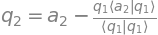

     ⎡ 2  ⎤
     ⎢    ⎥
     ⎢-2/5⎥
q₂ = ⎢    ⎥
     ⎢ 3  ⎥
     ⎢    ⎥
     ⎣4/5 ⎦

     ⎡2.0 ⎤
     ⎢    ⎥
     ⎢-0.4⎥
q₂ = ⎢    ⎥
     ⎢3.0 ⎥
     ⎢    ⎥
     ⎣0.8 ⎦

Normalizing the vector


     ⎡ 2⋅√345 ⎤
     ⎢ ────── ⎥
     ⎢   69   ⎥
     ⎢        ⎥
     ⎢-2⋅√345 ⎥
     ⎢────────⎥
     ⎢  345   ⎥
q₂ = ⎢        ⎥
     ⎢  √345  ⎥
     ⎢  ────  ⎥
     ⎢   23   ⎥
     ⎢        ⎥
     ⎢ 4⋅√345 ⎥
     ⎢ ────── ⎥
     ⎣  345   ⎦

     ⎡0.538381902058165 ⎤
     ⎢                  ⎥
     ⎢-0.107676380411633⎥
q₂ = ⎢                  ⎥
     ⎢0.807572853087248 ⎥
     ⎢                  ⎥
     ⎣0.215352760823266 ⎦

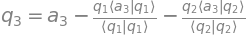

     ⎡176 ⎤
     ⎢─── ⎥
     ⎢ 69 ⎥
     ⎢    ⎥
     ⎢-49 ⎥
     ⎢────⎥
     ⎢ 69 ⎥
q₃ = ⎢    ⎥
     ⎢-50 ⎥
     ⎢────⎥
     ⎢ 23 ⎥
     ⎢    ⎥
     ⎢ 98 ⎥
     ⎢ ── ⎥
     ⎣ 69 ⎦

     ⎡ 2.55072463768116 ⎤
     ⎢                  ⎥
     ⎢-0.710144927536231⎥
q₃ = ⎢                  ⎥
     ⎢-2.17391304347826 ⎥
     ⎢                  ⎥
     ⎣ 1.42028985507246 ⎦

Normalizing the vector


     ⎡176⋅√65481 ⎤
     ⎢────────── ⎥
     ⎢  65481    ⎥
     ⎢           ⎥
     ⎢-49⋅√65481 ⎥
     ⎢───────────⎥
     ⎢   65481   ⎥
q₃ = ⎢           ⎥
     ⎢-50⋅√65481 ⎥
     ⎢───────────⎥
     ⎢   21827   ⎥
     ⎢           ⎥
     ⎢ 98⋅√65481 ⎥
     ⎢ ───────── ⎥
     ⎣   65481   ⎦

     ⎡0.687788668188414 ⎤
     ⎢                  ⎥
     ⎢-0.191486617847911⎥
q₃ = ⎢                  ⎥
     ⎢-0.586183524024216⎥
     ⎢                  ⎥
     ⎣0.382973235695821 ⎦

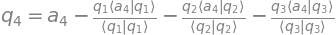

     ⎡ 270 ⎤
     ⎢ ─── ⎥
     ⎢  73 ⎥
     ⎢     ⎥
     ⎢ 216 ⎥
     ⎢ ─── ⎥
     ⎢  73 ⎥
q₄ = ⎢     ⎥
     ⎢-36  ⎥
     ⎢──── ⎥
     ⎢ 73  ⎥
     ⎢     ⎥
     ⎢-432 ⎥
     ⎢─────⎥
     ⎣  73 ⎦

     ⎡ 3.6986301369863  ⎤
     ⎢                  ⎥
     ⎢ 2.95890410958904 ⎥
q₄ = ⎢                  ⎥
     ⎢-0.493150684931506⎥
     ⎢                  ⎥
     ⎣-5.91780821917808 ⎦

Normalizing the vector


     ⎡ 15⋅√949 ⎤
     ⎢ ─────── ⎥
     ⎢   949   ⎥
     ⎢         ⎥
     ⎢ 12⋅√949 ⎥
     ⎢ ─────── ⎥
     ⎢   949   ⎥
q₄ = ⎢         ⎥
     ⎢-2⋅√949  ⎥
     ⎢──────── ⎥
     ⎢  949    ⎥
     ⎢         ⎥
     ⎢-24⋅√949 ⎥
     ⎢─────────⎥
     ⎣   949   ⎦

     ⎡ 0.486920604870896 ⎤
     ⎢                   ⎥
     ⎢ 0.389536483896717 ⎥
q₄ = ⎢                   ⎥
     ⎢-0.0649227473161195⎥
     ⎢                   ⎥
     ⎣-0.779072967793435 ⎦



The orthonormal vectors are:



     ⎡ 0  ⎤
     ⎢    ⎥
     ⎢2⋅√5⎥
     ⎢────⎥
     ⎢ 5  ⎥
q₁ = ⎢    ⎥
     ⎢ 0  ⎥
     ⎢    ⎥
     ⎢ √5 ⎥
     ⎢ ── ⎥
     ⎣ 5  ⎦

     ⎡ 2⋅√345 ⎤
     ⎢ ────── ⎥
     ⎢   69   ⎥
     ⎢        ⎥
     ⎢-2⋅√345 ⎥
     ⎢────────⎥
     ⎢  345   ⎥
q₂ = ⎢        ⎥
     ⎢  √345  ⎥
     ⎢  ────  ⎥
     ⎢   23   ⎥
     ⎢        ⎥
     ⎢ 4⋅√345 ⎥
     ⎢ ────── ⎥
     ⎣  345   ⎦

     ⎡176⋅√65481 ⎤
     ⎢────────── ⎥
     ⎢  65481    ⎥
     ⎢           ⎥
     ⎢-49⋅√65481 ⎥
     ⎢───────────⎥
     ⎢   65481   ⎥
q₃ = ⎢           ⎥
     ⎢-50⋅√65481 ⎥
     ⎢───────────⎥
     ⎢   21827   ⎥
     ⎢           ⎥
     ⎢ 98⋅√65481 ⎥
     ⎢ ───────── ⎥
     ⎣   65481   ⎦

     ⎡ 15⋅√949 ⎤
     ⎢ ─────── ⎥
     ⎢   949   ⎥
     ⎢         ⎥
     ⎢ 12⋅√949 ⎥
     ⎢ ─────── ⎥
     ⎢   949   ⎥
q₄ = ⎢         ⎥
     ⎢-2⋅√949  ⎥
     ⎢──────── ⎥
     ⎢  949    ⎥
     ⎢         ⎥
     ⎢-24⋅√949 ⎥
     ⎢─────────⎥
     ⎣   949   ⎦

(array([[ 0.        ,  0.89442719,  0.        ,  0.4472136 ],
        [ 0.5383819 , -0.10767638,  0.80757285,  0.21535276],
        [ 0.68778867, -0.19148662, -0.58618352,  0.38297324],
        [ 0.4869206 ,  0.38953648, -0.06492275, -0.77907297]]),
 [Matrix([
  [0],
  [2],
  [0],
  [1]]),
  Matrix([
  [   2],
  [-2/5],
  [   3],
  [ 4/5]]),
  Matrix([
  [176/69],
  [-49/69],
  [-50/23],
  [ 98/69]]),
  Matrix([
  [ 270/73],
  [ 216/73],
  [ -36/73],
  [-432/73]])],
 [Matrix([
  [          0],
  [2*sqrt(5)/5],
  [          0],
  [  sqrt(5)/5]]),
  Matrix([
  [  2*sqrt(345)/69],
  [-2*sqrt(345)/345],
  [    sqrt(345)/23],
  [ 4*sqrt(345)/345]]),
  Matrix([
  [176*sqrt(65481)/65481],
  [-49*sqrt(65481)/65481],
  [-50*sqrt(65481)/21827],
  [ 98*sqrt(65481)/65481]]),
  Matrix([
  [ 15*sqrt(949)/949],
  [ 12*sqrt(949)/949],
  [ -2*sqrt(949)/949],
  [-24*sqrt(949)/949]])])

In [17]:
#gram_schmidt_orthonormalization
a = np.array([[0,2,0,1],[2,2,3,2],[4,-3,0,1], [6,1,-6,-5]])
b = [1,1,1,1]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='gram_schmidt_orthonormalization').solve(a = a, b = b)

-----------------------------------------------------------------------------

#  QRFactorization

Input Matrix:


    ⎡1  0  0⎤
    ⎢       ⎥
    ⎢1  1  0⎥
A = ⎢       ⎥
    ⎢1  1  1⎥
    ⎢       ⎥
    ⎣1  1  1⎦


To find QR factorization of A we need to find




Where Q is the matrix having orthonormal column vectors found by applying Gram Schmidt Orthonormalization to the columns of A 

Step-1: Find Q using Gram Schmidt Orthonormalization

Input vectors: 


     ⎡1⎤
     ⎢ ⎥
     ⎢1⎥
a₁ = ⎢ ⎥
     ⎢1⎥
     ⎢ ⎥
     ⎣1⎦

     ⎡0⎤
     ⎢ ⎥
     ⎢1⎥
a₂ = ⎢ ⎥
     ⎢1⎥
     ⎢ ⎥
     ⎣1⎦

     ⎡0⎤
     ⎢ ⎥
     ⎢0⎥
a₃ = ⎢ ⎥
     ⎢1⎥
     ⎢ ⎥
     ⎣1⎦



Initiating Gram Schmidt Orthonormalization to find Orthonornal vectors q




     ⎡1⎤
     ⎢ ⎥
     ⎢1⎥
q₁ = ⎢ ⎥
     ⎢1⎥
     ⎢ ⎥
     ⎣1⎦

     ⎡1.0⎤
     ⎢   ⎥
     ⎢1.0⎥
q₁ = ⎢   ⎥
     ⎢1.0⎥
     ⎢   ⎥
     ⎣1.0⎦

Normalizing the vector


     ⎡1/2⎤
     ⎢   ⎥
     ⎢1/2⎥
q₁ = ⎢   ⎥
     ⎢1/2⎥
     ⎢   ⎥
     ⎣1/2⎦

     ⎡0.5⎤
     ⎢   ⎥
     ⎢0.5⎥
q₁ = ⎢   ⎥
     ⎢0.5⎥
     ⎢   ⎥
     ⎣0.5⎦

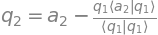

     ⎡-3/4⎤
     ⎢    ⎥
     ⎢1/4 ⎥
q₂ = ⎢    ⎥
     ⎢1/4 ⎥
     ⎢    ⎥
     ⎣1/4 ⎦

     ⎡-0.75⎤
     ⎢     ⎥
     ⎢0.25 ⎥
q₂ = ⎢     ⎥
     ⎢0.25 ⎥
     ⎢     ⎥
     ⎣0.25 ⎦

Normalizing the vector


     ⎡-√3 ⎤
     ⎢────⎥
     ⎢ 2  ⎥
     ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
q₂ = ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
     ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎣ 6  ⎦

     ⎡-0.866025403784439⎤
     ⎢                  ⎥
     ⎢0.288675134594813 ⎥
q₂ = ⎢                  ⎥
     ⎢0.288675134594813 ⎥
     ⎢                  ⎥
     ⎣0.288675134594813 ⎦

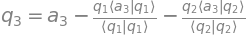

     ⎡ 0  ⎤
     ⎢    ⎥
     ⎢-2/3⎥
q₃ = ⎢    ⎥
     ⎢1/3 ⎥
     ⎢    ⎥
     ⎣1/3 ⎦

     ⎡        0         ⎤
     ⎢                  ⎥
     ⎢-0.666666666666667⎥
q₃ = ⎢                  ⎥
     ⎢0.333333333333333 ⎥
     ⎢                  ⎥
     ⎣0.333333333333333 ⎦

Normalizing the vector


     ⎡ 0  ⎤
     ⎢    ⎥
     ⎢-√6 ⎥
     ⎢────⎥
     ⎢ 3  ⎥
     ⎢    ⎥
q₃ = ⎢ √6 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
     ⎢    ⎥
     ⎢ √6 ⎥
     ⎢ ── ⎥
     ⎣ 6  ⎦

     ⎡        0         ⎤
     ⎢                  ⎥
     ⎢-0.816496580927726⎥
q₃ = ⎢                  ⎥
     ⎢0.408248290463863 ⎥
     ⎢                  ⎥
     ⎣0.408248290463863 ⎦



The orthonormal vectors are:



     ⎡1/2⎤
     ⎢   ⎥
     ⎢1/2⎥
q₁ = ⎢   ⎥
     ⎢1/2⎥
     ⎢   ⎥
     ⎣1/2⎦

     ⎡-√3 ⎤
     ⎢────⎥
     ⎢ 2  ⎥
     ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
q₂ = ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
     ⎢    ⎥
     ⎢ √3 ⎥
     ⎢ ── ⎥
     ⎣ 6  ⎦

     ⎡ 0  ⎤
     ⎢    ⎥
     ⎢-√6 ⎥
     ⎢────⎥
     ⎢ 3  ⎥
     ⎢    ⎥
q₃ = ⎢ √6 ⎥
     ⎢ ── ⎥
     ⎢ 6  ⎥
     ⎢    ⎥
     ⎢ √6 ⎥
     ⎢ ── ⎥
     ⎣ 6  ⎦

    ⎡     -√3       ⎤
    ⎢1/2  ────   0  ⎥
    ⎢      2        ⎥
    ⎢               ⎥
    ⎢      √3   -√6 ⎥
    ⎢1/2   ──   ────⎥
    ⎢      6     3  ⎥
Q = ⎢               ⎥
    ⎢      √3    √6 ⎥
    ⎢1/2   ──    ── ⎥
    ⎢      6     6  ⎥
    ⎢               ⎥
    ⎢      √3    √6 ⎥
    ⎢1/2   ──    ── ⎥
    ⎣      6     6  ⎦


Step-1: Use Q to get R



                     T          
    ⎡     -√3       ⎤           
    ⎢1/2  ────   0  ⎥           
    ⎢      2        ⎥           
    ⎢               ⎥           
    ⎢      √3   -√6 ⎥  ⎡1  0  0⎤
    ⎢1/2   ──   ────⎥  ⎢       ⎥
    ⎢      6     3  ⎥  ⎢1  1  0⎥
R = ⎢               ⎥ ⋅⎢       ⎥
    ⎢      √3    √6 ⎥  ⎢1  1  1⎥
    ⎢1/2   ──    ── ⎥  ⎢       ⎥
    ⎢      6     6  ⎥  ⎣1  1  1⎦
    ⎢               ⎥           
    ⎢      √3    √6 ⎥           
    ⎢1/2   ──    ── ⎥           
    ⎣      6     6  ⎦           

    ⎡2  3/2  1 ⎤
    ⎢          ⎥
    ⎢   √3   √3⎥
    ⎢0  ──   ──⎥
R = ⎢   2    3 ⎥
    ⎢          ⎥
    ⎢        √6⎥
    ⎢0   0   ──⎥
    ⎣        3 ⎦

In [18]:
#QRFactorization
A = np.array([[1,0,0],[1,1,0],[1,1,1],[1,1,1]])
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='qr_factorization').solve(a=A)

------------------------------------------

# LU_Crout

In [19]:
a = np.array([[2,4,-6],[1,5,3],[1,3,2]])
b = [4,10,5]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='lu_crout').solve(a = a, b = b)

Starting Dolittle method for LU decomposition
Input Matrix A:



⎡2  4  -6⎤
⎢        ⎥
⎢1  5  3 ⎥
⎢        ⎥
⎣1  3  2 ⎦


A = LU, where



    ⎡l₀₀   0    0 ⎤
    ⎢             ⎥
L = ⎢l₁₀  l₁₁   0 ⎥
    ⎢             ⎥
    ⎣l₂₀  l₂₁  l₂₂⎦


and



    ⎡1  u₀₁  u₀₂⎤
    ⎢           ⎥
U = ⎢0   1   u₁₂⎥
    ⎢           ⎥
    ⎣0   0    1 ⎦

      ⎡l₀₀   0    0 ⎤ ⎡1  u₀₁  u₀₂⎤
      ⎢             ⎥ ⎢           ⎥
L⋅U = ⎢l₁₀  l₁₁   0 ⎥⋅⎢0   1   u₁₂⎥
      ⎢             ⎥ ⎢           ⎥
      ⎣l₂₀  l₂₁  l₂₂⎦ ⎣0   0    1 ⎦

      ⎡l₀₀     l₀₀⋅u₀₁             l₀₀⋅u₀₂        ⎤
      ⎢                                           ⎥
L⋅U = ⎢l₁₀  l₁₀⋅u₀₁ + l₁₁     l₁₀⋅u₀₂ + l₁₁⋅u₁₂   ⎥
      ⎢                                           ⎥
      ⎣l₂₀  l₂₀⋅u₀₁ + l₂₁  l₂₀⋅u₀₂ + l₂₁⋅u₁₂ + l₂₂⎦


On equating this with A, we get


⎡2  4  -6⎤   ⎡l₀₀     l₀₀⋅u₀₁             l₀₀⋅u₀₂        ⎤
⎢        ⎥   ⎢                                           ⎥
⎢1  5  3 ⎥ = ⎢l₁₀  l₁₀⋅u₀₁ + l₁₁     l₁₀⋅u₀₂ + l₁₁⋅u₁₂   ⎥
⎢        ⎥   ⎢                                           ⎥
⎣1  3  2 ⎦   ⎣l₂₀  l₂₀⋅u₀₁ + l₂₁  l₂₀⋅u₀₂ + l₂₁⋅u₁₂ + l₂₂⎦


Solving the above equations, we get



    ⎡2  0  0⎤
    ⎢       ⎥
L = ⎢1  3  0⎥
    ⎢       ⎥
    ⎣1  1  3⎦


and



    ⎡1  2  -3⎤
    ⎢        ⎥
U = ⎢0  1  2 ⎥
    ⎢        ⎥
    ⎣0  0  1 ⎦


A = LU, Thus, the system Ax = b is

LUx = b

Let Ux = y, then

Ly = b

Step-1: Solve Ly = b, to find y


⎡2  0  0⎤     ⎡4 ⎤
⎢       ⎥     ⎢  ⎥
⎢1  3  0⎥⋅y = ⎢10⎥
⎢       ⎥     ⎢  ⎥
⎣1  1  3⎦     ⎣5 ⎦

⎡2  0  0⎤ ⎡y₀₀⎤   ⎡4 ⎤
⎢       ⎥ ⎢   ⎥   ⎢  ⎥
⎢1  3  0⎥⋅⎢y₁₀⎥ = ⎢10⎥
⎢       ⎥ ⎢   ⎥   ⎢  ⎥
⎣1  1  3⎦ ⎣y₂₀⎦   ⎣5 ⎦

By Applying forward substitution, we get


    ⎡ 2.0  ⎤
    ⎢      ⎥
y = ⎢2.667 ⎥
    ⎢      ⎥
    ⎣0.1111⎦

Step-2: Now solve Ux = y, to find x


⎡1  2  -3⎤     ⎡ 2.0  ⎤
⎢        ⎥     ⎢      ⎥
⎢0  1  2 ⎥⋅x = ⎢2.667 ⎥
⎢        ⎥     ⎢      ⎥
⎣0  0  1 ⎦     ⎣0.1111⎦

⎡1  2  -3⎤ ⎡x₀₀⎤   ⎡ 2.0  ⎤
⎢        ⎥ ⎢   ⎥   ⎢      ⎥
⎢0  1  2 ⎥⋅⎢x₁₀⎥ = ⎢2.667 ⎥
⎢        ⎥ ⎢   ⎥   ⎢      ⎥
⎣0  0  1 ⎦ ⎣x₂₀⎦   ⎣0.1111⎦

By Applying back substitution, we get


    ⎡-2.556⎤
    ⎢      ⎥
x = ⎢2.445 ⎥
    ⎢      ⎥
    ⎣0.1111⎦

-------------------------------------------------------------------------

# Condition_Number

In [20]:
a = np.array([[2,4,-6],[1,5,3],[1,3,2]])
b = [4,10,5]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='condition_number').solve(a=a, b=b, pivoting=True, rounding_digit=4)

Finding condition number
Input Matrix:

[[ 2  4 -6]
 [ 1  5  3]
 [ 1  3  2]]


Condition Number(1): 40.0
Condition Number(inf): 46.0


---------------------------------------------

# SVD

In [22]:
a = np.array([[1,1,0],[0,0,1]])
#b = [4,10,5]
lsf = LinearSystemsFactory()
lsf.get_linear_system(system_type='svd').solve(a=a, rounding_digit=4)

Input Matrix:


    ⎡1  1  0⎤
A = ⎢       ⎥
    ⎣0  0  1⎦


Constructing Singular Value Decomposition of A




Step-1: Find eigenvalues of AᵀA


                T          
 T     ⎡1  1  0⎤  ⎡1  1  0⎤
A ⋅A = ⎢       ⎥ ⋅⎢       ⎥
       ⎣0  0  1⎦  ⎣0  0  1⎦

       ⎡1  1  0⎤
 T     ⎢       ⎥
A ⋅A = ⎢1  1  0⎥
       ⎢       ⎥
       ⎣0  0  1⎦


Eigenvalues of AᵀA are



Step-2: Setup V 

V is the Matrix with columns as Eigenvectors of AᵀA 


    ⎡√2     -√2 ⎤
    ⎢──  0  ────⎥
    ⎢2       2  ⎥
    ⎢           ⎥
V = ⎢√2      √2 ⎥
    ⎢──  0   ── ⎥
    ⎢2       2  ⎥
    ⎢           ⎥
    ⎣0   1   0  ⎦


Step-3: Setup  Σ

The square roots of Eigenvalues of AᵀA are singular values




Discarding the 0 singular values


Σ is the matrix of same shape as A conatining non zero singular values along diagonal



    ⎡√2  0  0⎤
Σ = ⎢        ⎥
    ⎣0   1  0⎦


Step-4: Cunstruct U


   ⎡1⎤
 = ⎢ ⎥
   ⎣0⎦

   ⎡0⎤
 = ⎢ ⎥
   ⎣1⎦

    ⎡1  0⎤
U = ⎢    ⎥
    ⎣0  1⎦


Singular Value decomposition of A is



                                   T
                      ⎡√2     -√2 ⎤ 
                      ⎢──  0  ────⎥ 
                      ⎢2       2  ⎥ 
    ⎡1  0⎤ ⎡√2  0  0⎤ ⎢           ⎥ 
A = ⎢    ⎥⋅⎢        ⎥⋅⎢√2      √2 ⎥ 
    ⎣0  1⎦ ⎣0   1  0⎦ ⎢──  0   ── ⎥ 
                      ⎢2       2  ⎥ 
                      ⎢           ⎥ 
                      ⎣0   1   0  ⎦ 